## CoT Final Report

In [15]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as scs

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA

import pygam
from pygam import LinearGAM
from pygam import s,l,f,te

import warnings
import time
warnings.filterwarnings("ignore")



In [7]:
df=pd.read_csv('Data_Weekly_20201204.csv',index_col = "Date")

In [8]:
def plotMissing(df,save=False,title='Missing Values'):
    #Missing value plot
    plt.figure(figsize=(8,6))
    sns.heatmap(df.isnull(),cbar=False)
    #sns.heatmap(df.iloc[np.unique(np.where(df.isnull())[0]),:].isnull(),cbar=False)
    plt.title('Missing Value')
    plt.tight_layout()
    if save:
        plt.savefig(title,dpi=300)
    plt.show()

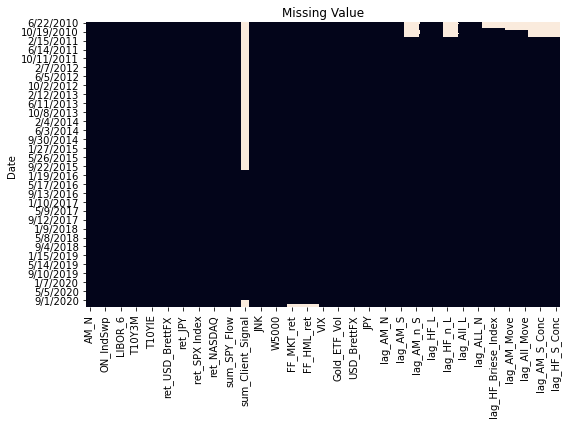

In [9]:
plotMissing(df)

In [10]:
#Set by individual user; the below are prices, we'd prefer returns
cols = ['XAU','JNK', 'SPX Index','W5000', 'NASDAQ', 'USD_TWFX', 'USD_BrettFX', 'EUR',  'JPY','JNK_Volm']
df = df.drop(columns = cols)

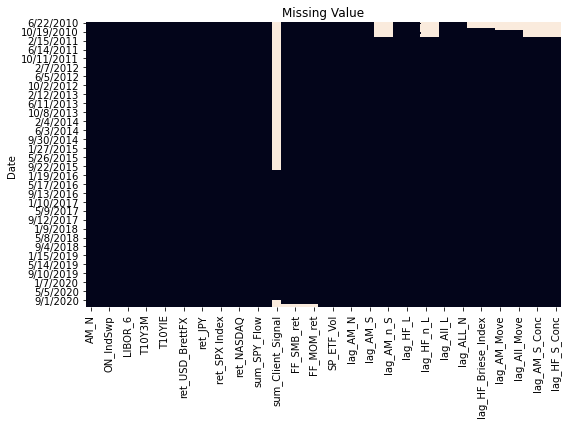

In [11]:
plotMissing(df)

__Response Variable Structure__

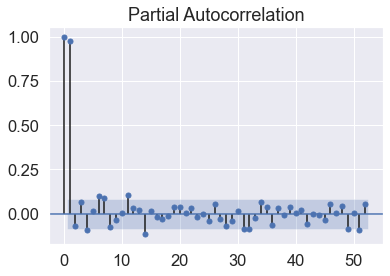

<Figure size 1440x720 with 0 Axes>

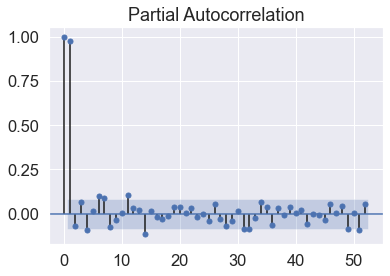

In [19]:
fig = plt.figure(figsize = (20,10))
sns.set(font_scale = 1.5)
axs = fig.subplots(1,0)
plot_pacf(x=df['AM_N'], lags = 52,alpha = .05)

In [12]:
#Correlation: Compute the correlation matrix
def plotCorr(labeled,save=False):
    s=10
    corr = labeled.iloc[:,:-1].corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    #sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(corr, square=True,linewidths=.4,annot=True,annot_kws={"size":8},fmt='.1f',cbar_kws={"shrink": .4}, mask=mask, cmap="coolwarm")
    # Draw the heatmap with the mask and correct aspect ratio
    plt.tight_layout()
    plt.title('Correlation Matrix',size=s)
    if save:
        plt.savefig('Correlation Matrix',dpi=300)
    plt.show()

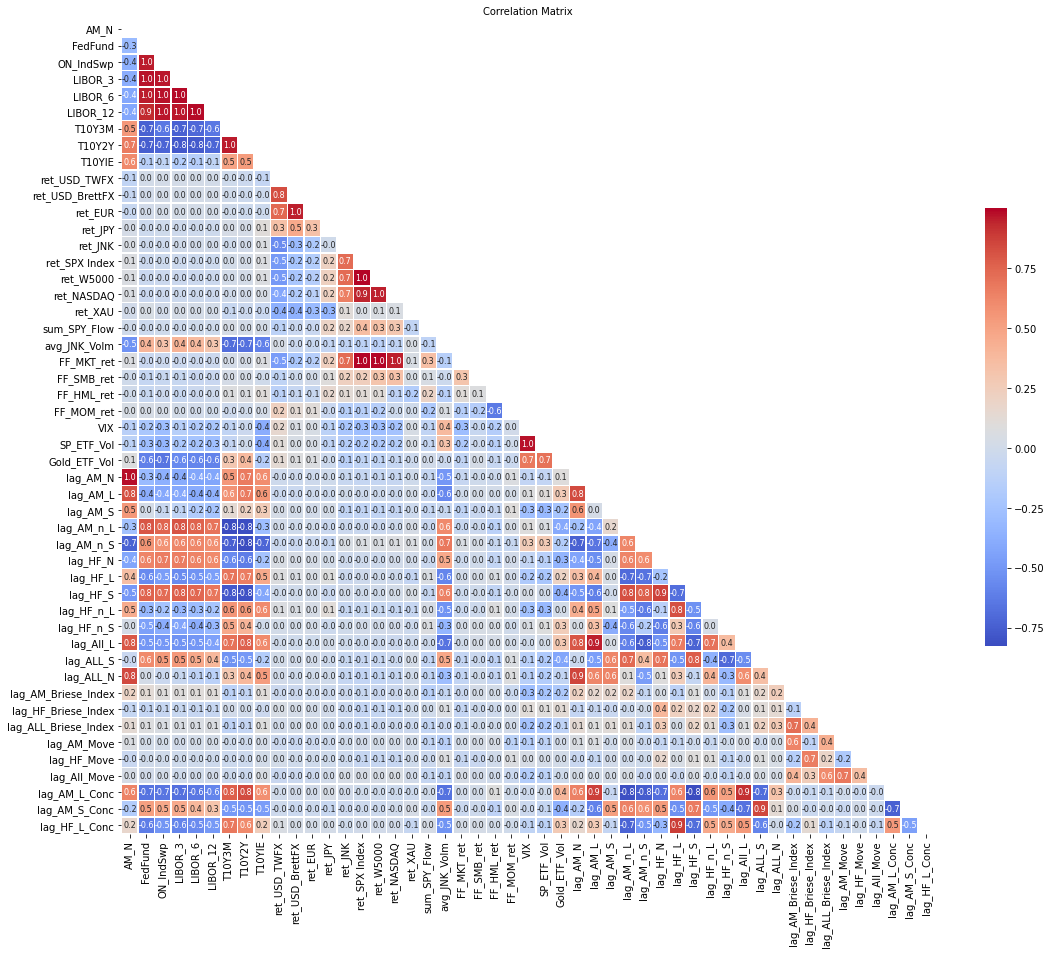

In [13]:
plotCorr(df,save=False)

__Predictor Distributions__

In [265]:
Asset = {'AM Position':['lag_AM_N','lag_AM_L','lag_AM_S'],
         'HF Position':['lag_HF_N','lag_HF_L','lag_HF_S'],
         'All Position':['lag_All_L', 'lag_ALL_S', 'lag_ALL_N'],
         'Concentration':['lag_AM_L_Conc', 'lag_AM_S_Conc','lag_HF_L_Conc', 'lag_HF_S_Conc'],
         'Sentiment':['lag_AM_Briese_Index', 'lag_HF_Briese_Index', 'lag_ALL_Briese_Index'],
         'Movement' :['lag_AM_Move','lag_HF_Move','lag_All_Move'],
         'Int_Rate':['FedFund', 'ON_IndSwp'],
         'LIBOR':['LIBOR_3', 'LIBOR_6','LIBOR_12'],
         'YTM Spread':['T10Y3M','T10Y2Y'],
         'Inflation':['T10YIE'],
         'FX Returns': [ 'ret_USD_TWFX','ret_USD_BrettFX', 'ret_EUR','ret_JPY'],      
         'Junk_Bond Returns':['ret_JNK'],
         'Equity Returns':['ret_SPX Index','ret_W5000', 'ret_NASDAQ'],
         'FamaFrench':['FF_MKT_ret', 'FF_SMB_ret', 'FF_HML_ret', 'FF_MOM_ret'],
         'ETF_Flows':['sum_SPY_Flow'],
         'Vol':['VIX', 'SP_ETF_Vol', 'Gold_ETF_Vol'],
         'Signal':['sum_Client_Signal'],
         'Commodity':['ret_XAU']       
        }
key_list = list(Asset.keys())

In [266]:
df.columns

Index(['AM_N', 'FedFund', 'ON_IndSwp', 'LIBOR_3', 'LIBOR_6', 'LIBOR_12',
       'T10Y3M', 'T10Y2Y', 'T10YIE', 'ret_USD_TWFX', 'ret_USD_BrettFX',
       'ret_EUR', 'ret_JPY', 'ret_JNK', 'ret_SPX Index', 'ret_W5000',
       'ret_NASDAQ', 'ret_XAU', 'sum_SPY_Flow', 'avg_JNK_Volm',
       'sum_Client_Signal', 'FF_MKT_ret', 'FF_SMB_ret', 'FF_HML_ret',
       'FF_MOM_ret', 'VIX', 'SP_ETF_Vol', 'Gold_ETF_Vol', 'lag_AM_N',
       'lag_AM_L', 'lag_AM_S', 'lag_AM_n_L', 'lag_AM_n_S', 'lag_HF_N',
       'lag_HF_L', 'lag_HF_S', 'lag_HF_n_L', 'lag_HF_n_S', 'lag_All_L',
       'lag_ALL_S', 'lag_ALL_N', 'lag_AM_Briese_Index', 'lag_HF_Briese_Index',
       'lag_ALL_Briese_Index', 'lag_AM_Move', 'lag_HF_Move', 'lag_All_Move',
       'lag_AM_L_Conc', 'lag_AM_S_Conc', 'lag_HF_L_Conc', 'lag_HF_S_Conc'],
      dtype='object')

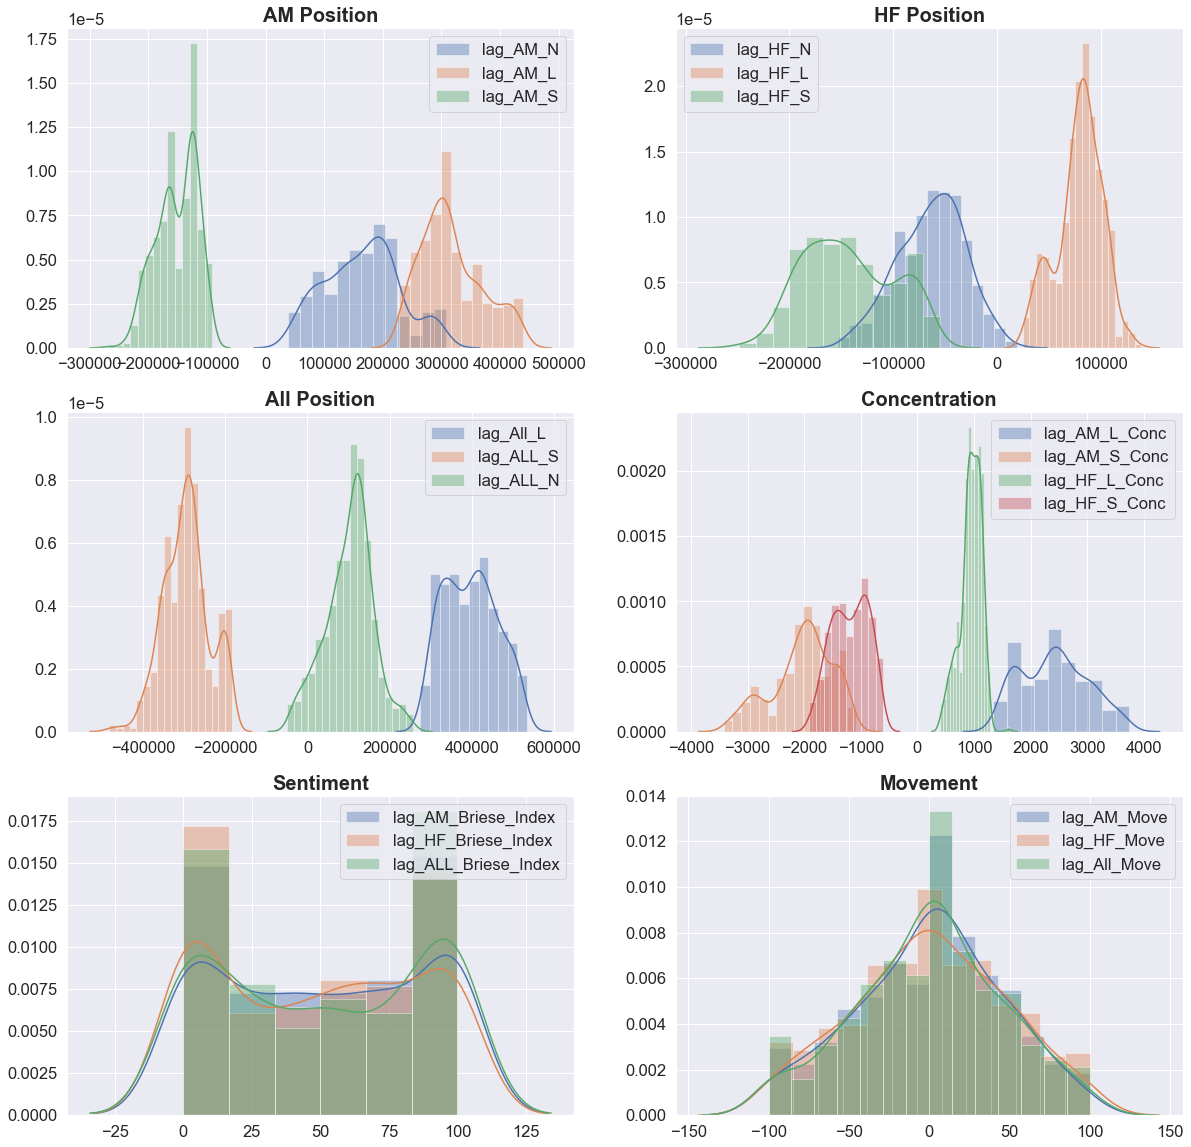

In [267]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[0:6]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        #if(item_names[i][-2:]=="_S"):
        #    x = pd.Series(-df.loc[:,item_names[i]], name = "")
        #else:
        x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [ ]:
plt.scatter(df['lag_AM_Bries'])

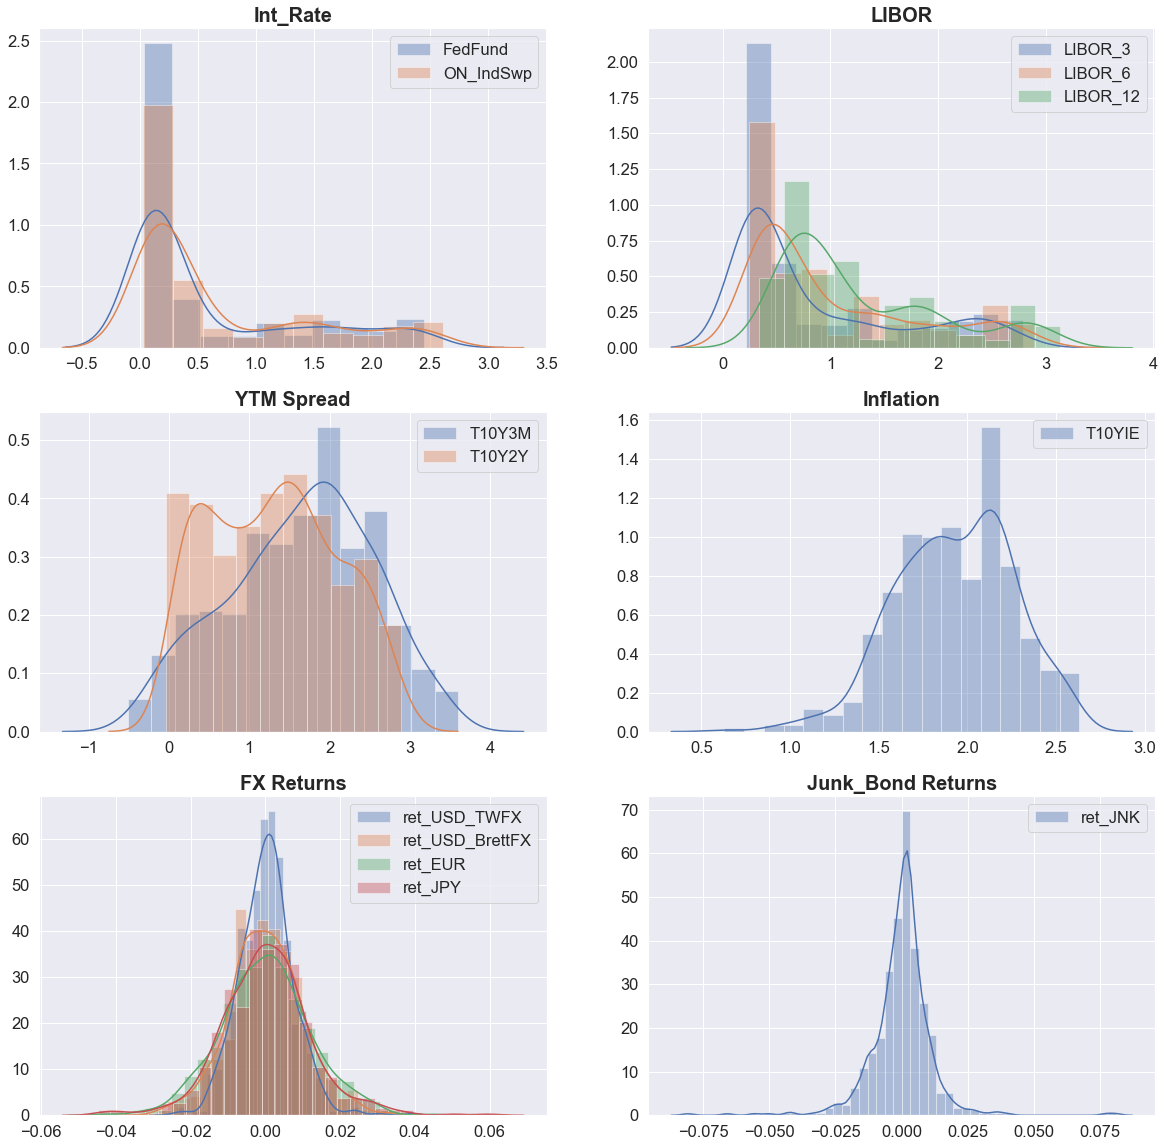

In [268]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[6:12]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            scaler = preprocessing.StandardScaler()
            scaled_sig = scaler.fit_transform(df.loc[:,item_names[i]])
            x = pd.Series(scaled_sig, name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [269]:
z = df['sum_Client_Signal']
z = z.dropna()
mean = np.mean(z)
std = np.std(z)
z = (z-mean)/std
z

Date
2015-12-01    1.061159
2015-12-08   -0.386539
2015-12-15    0.819238
2015-12-22   -0.616791
2015-12-29    0.564083
                ...   
2020-08-11    0.046479
2020-08-18    0.247578
2020-08-25    0.010922
2020-09-01    1.080648
2020-09-08    1.036306
Name: sum_Client_Signal, Length: 247, dtype: float64

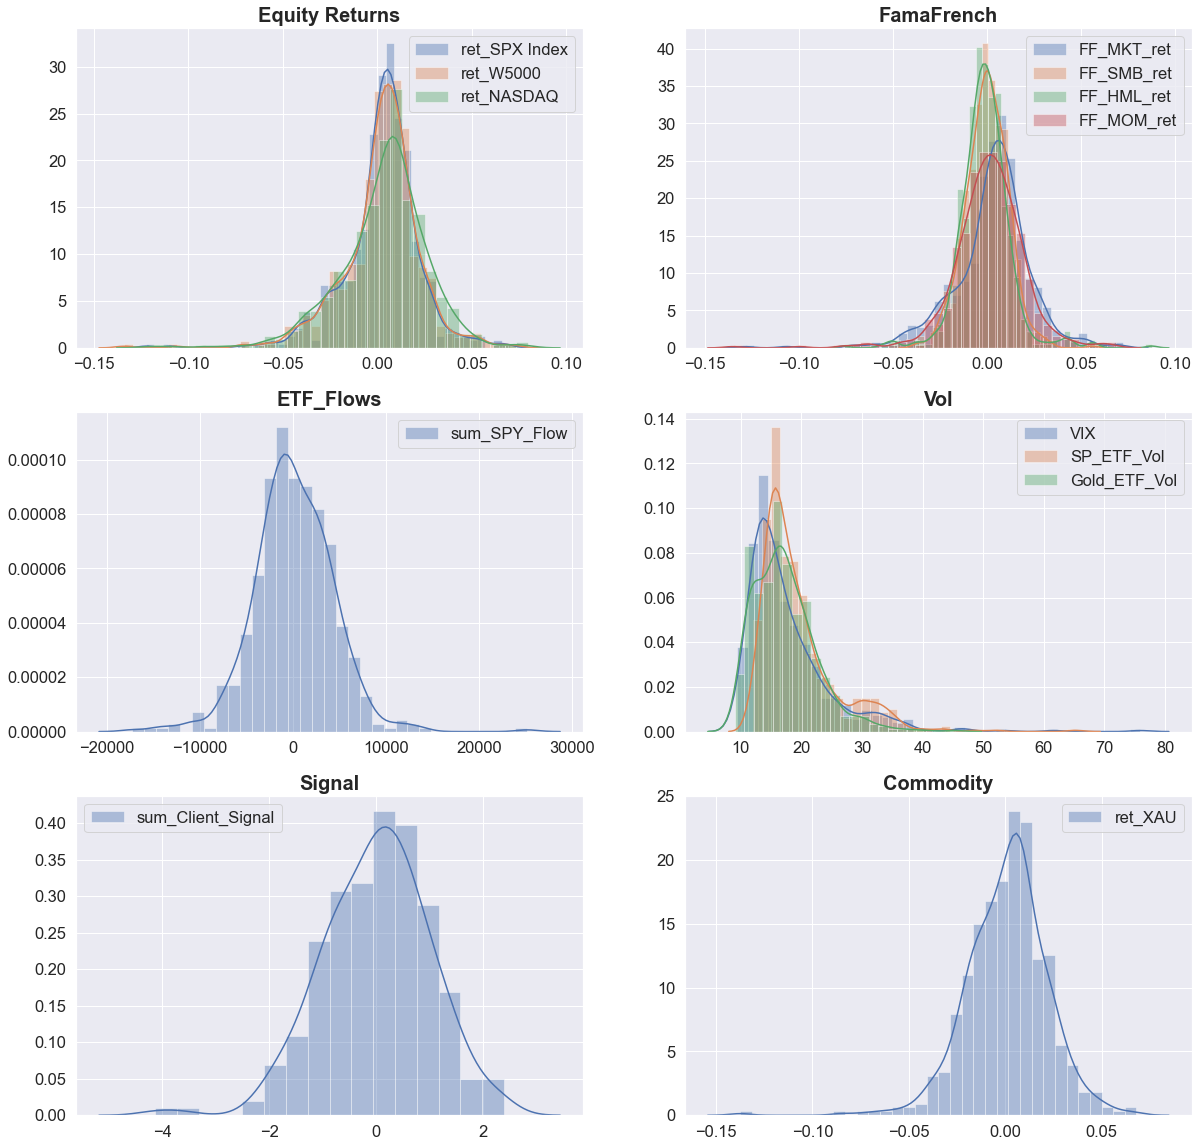

In [270]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[12:18]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            x = pd.Series(z, name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [271]:
df['year'] = df.index.year
y_train = df['AM_N']

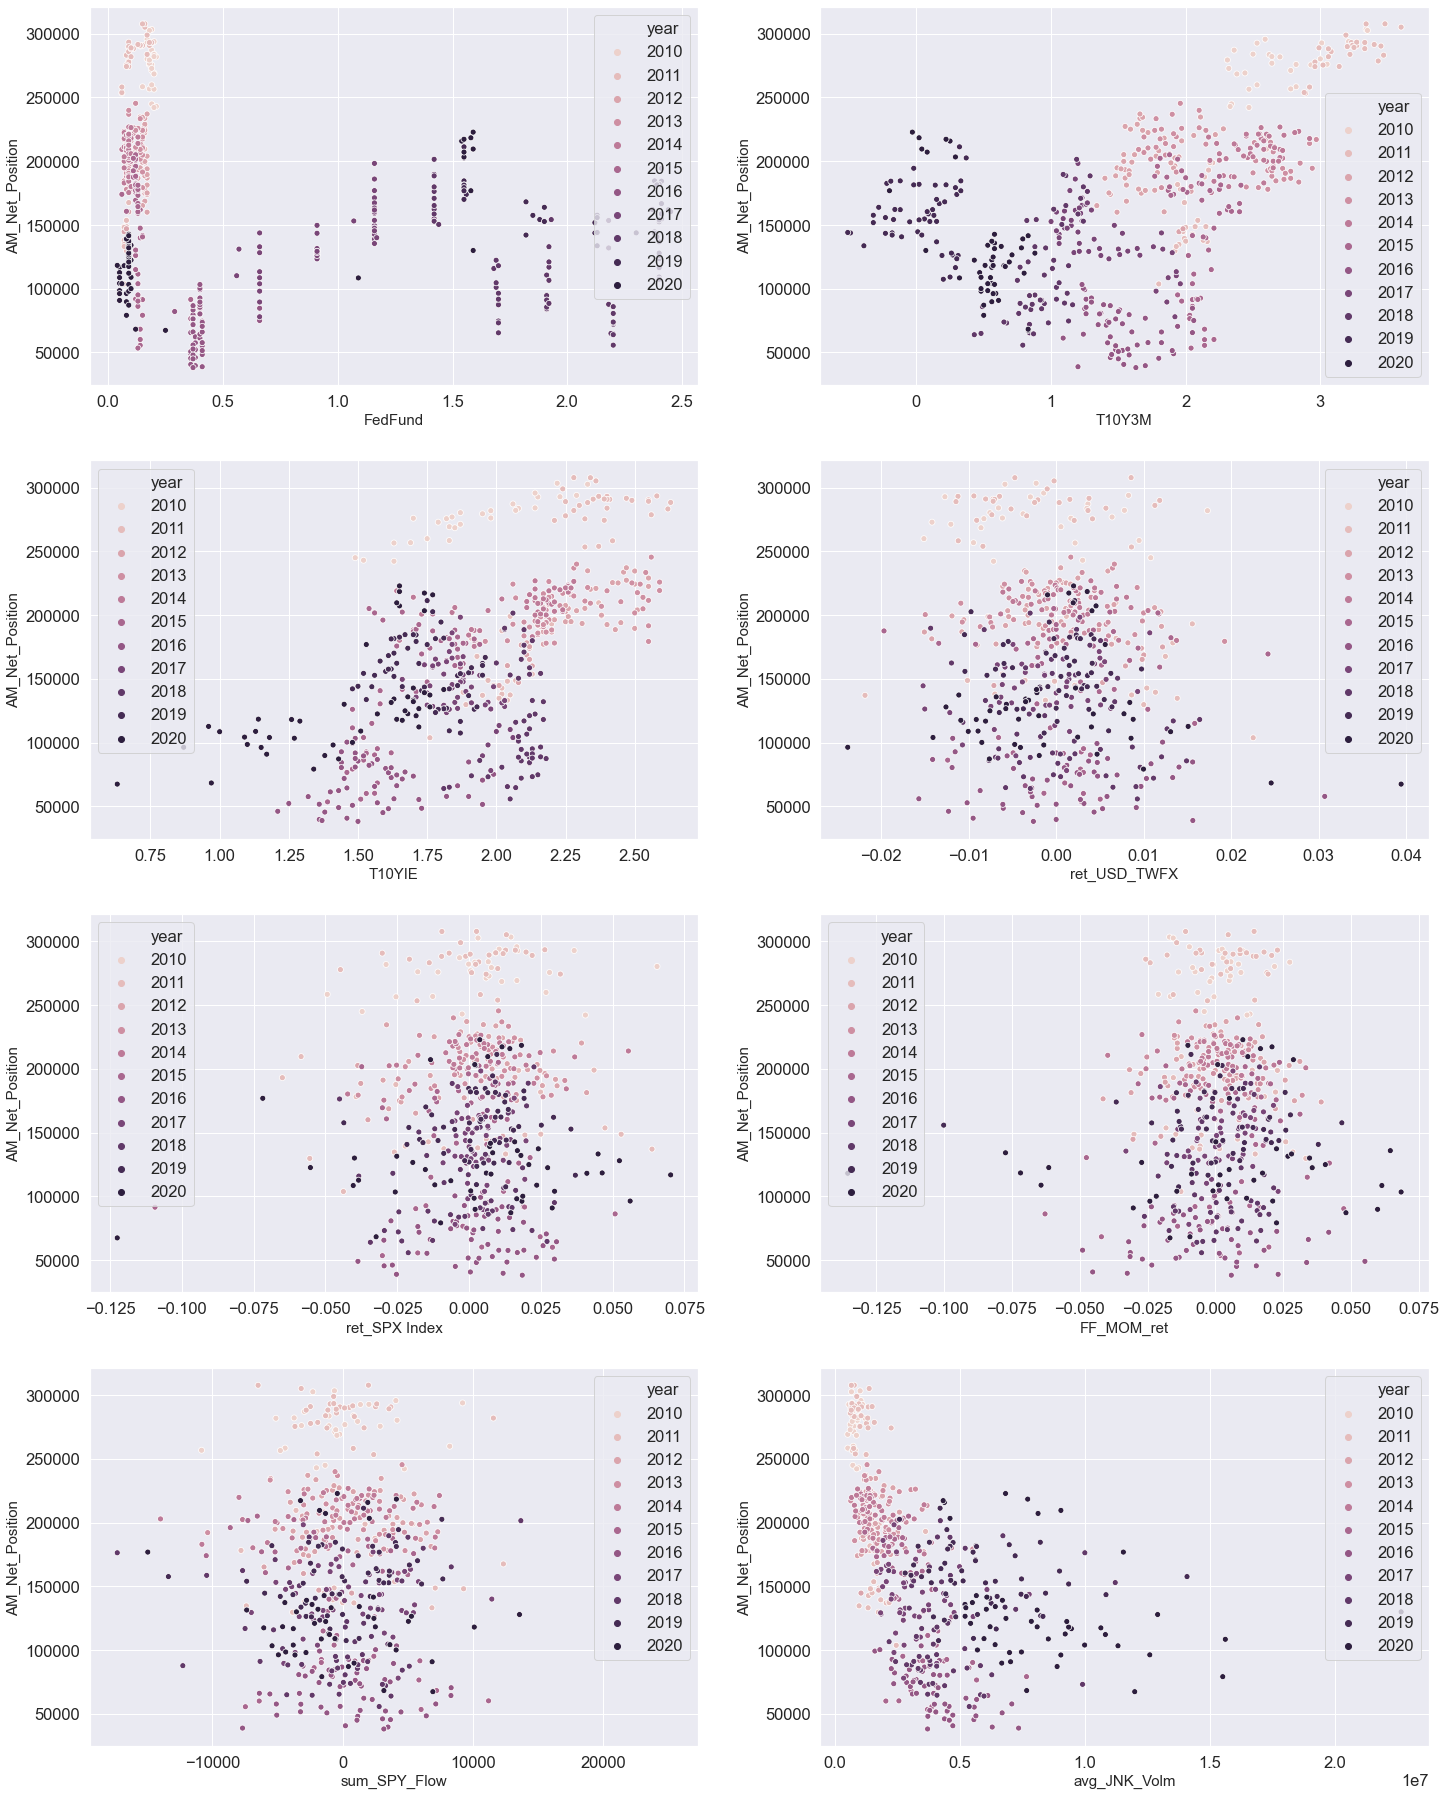

In [272]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['FedFund','T10Y3M','T10YIE','ret_USD_TWFX','ret_SPX Index','FF_MOM_ret','sum_SPY_Flow','avg_JNK_Volm']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]], y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

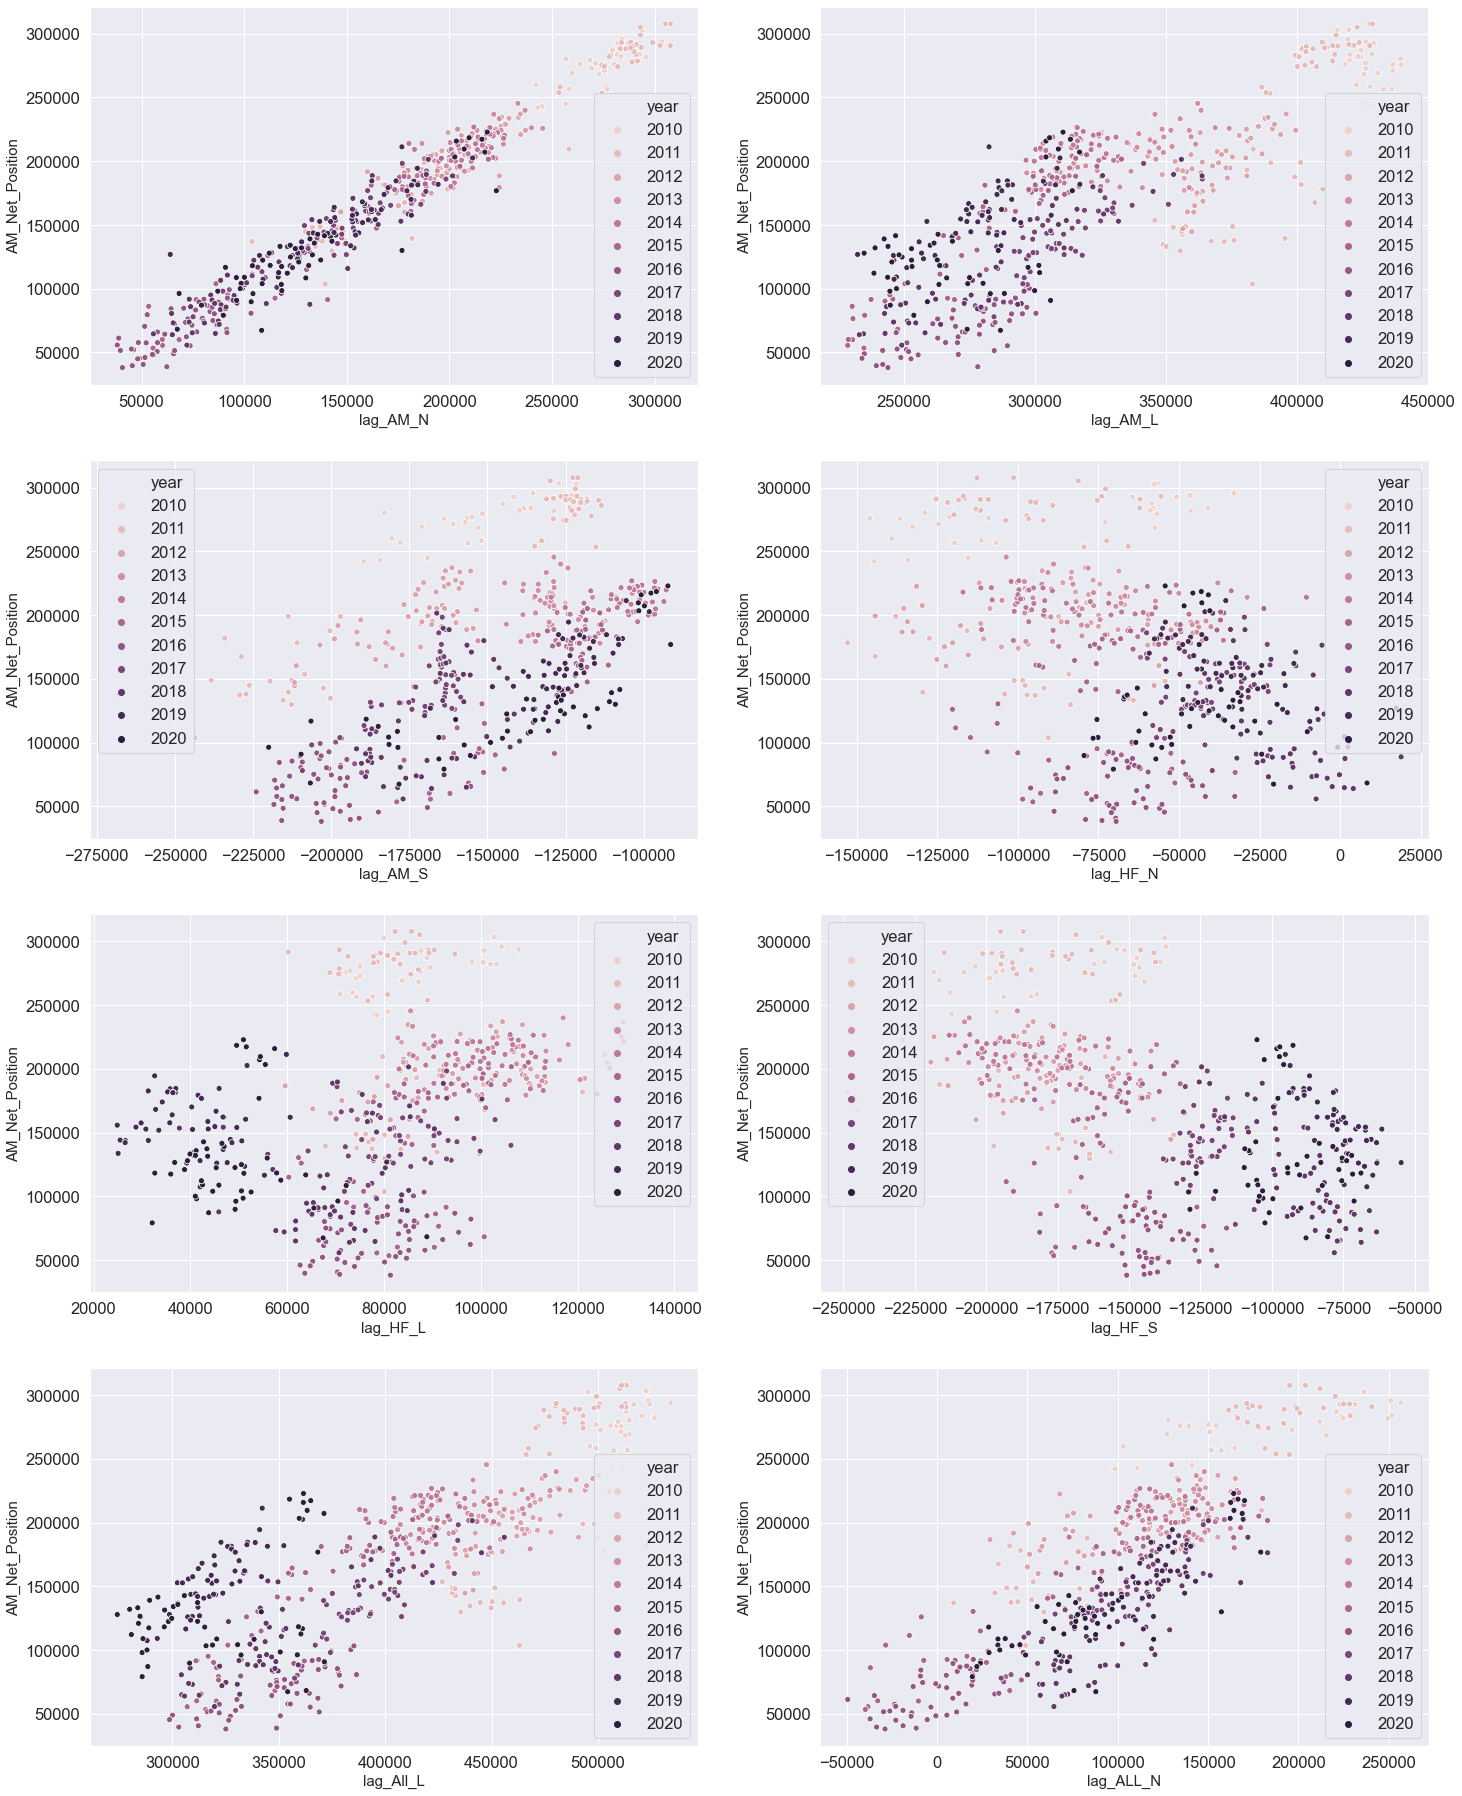

In [273]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_N','lag_AM_L', 'lag_AM_S', 'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_N']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]], y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


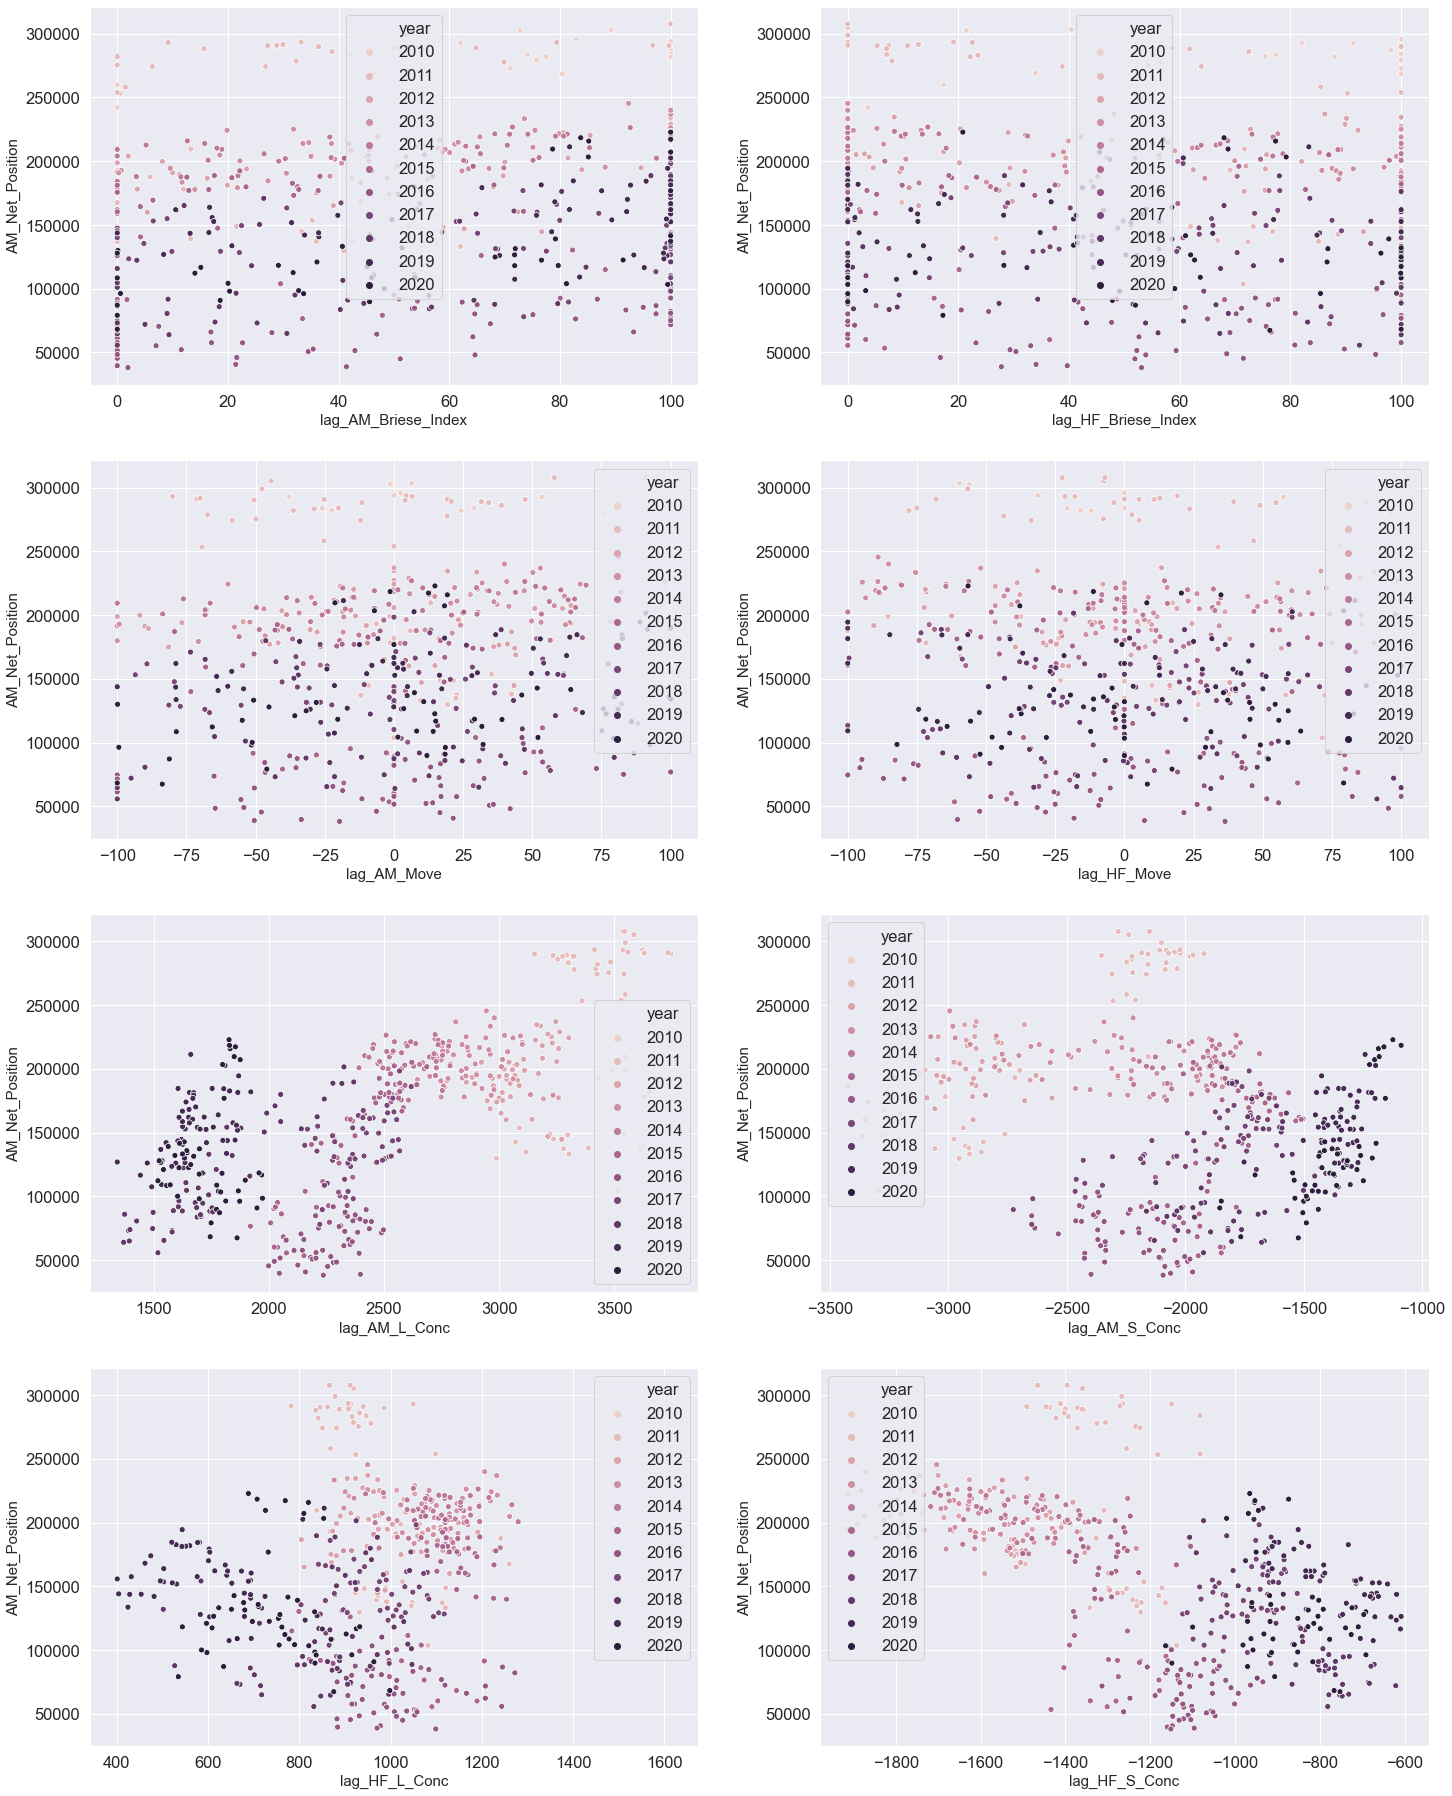

In [274]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_Briese_Index', 'lag_HF_Briese_Index','lag_AM_Move', 'lag_HF_Move', 
       'lag_AM_L_Conc', 'lag_AM_S_Conc', 'lag_HF_L_Conc', 'lag_HF_S_Conc']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]],y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


__Standardization__

In [275]:
df = df.dropna(axis = 1)
df = df.drop(columns = 'year')

In [300]:
(541-135)//9

45

In [303]:
df.shape[0]

541

In [ ]:
df

In [324]:
    
def RollingLasso(est_window = 135, pred_window = 9):    
    periods = df.shape[0]
    est = est_window
    wind = pred_window
    rebal_count = (periods-est)//wind

    alphas = []
    pred = []
    MSE = []
    MAE = []
    var_sel = {new_list: [] for new_list in range(rebal_count)} 
    y_true = []
    for i in range (0,45):
        # remove predictors which are not present for the period in question
        # start by taking the full estimation and prediction window
        #print("Round :",i+1)
        full = df.iloc[i*wind:est+i*wind+wind,:].dropna(axis = 1)
        #print("Shape of full:", full.shape)
        #now we can take train and test
        full_train = full.iloc[:est,:]
        #print("Shape of full_train:", full_train.shape)
        full_test = full.iloc[ est : est+ wind ,:]
        #print("Shape of full_test:", full_test.shape)
        #print("test slice calcs=",est + i * wind,":", est+ i*wind + wind )
        X_train = full_train.iloc[:,1:]
        y_train = full_train.iloc[:,0]
        X_test = full_test.iloc[:,1:]
        y_test = full_test.iloc[:,0]

        #standardize our predictors (std 1, mean 0)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        #fit our model to the training set
        lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
        lasso.fit(X_train_std, y_train)

        #predict
        forecast = lasso.predict(X_test_std)
        
        #store results
        var_sel[i] = list(X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4])
        alphas.append(np.log(lasso.alpha_))
        pred.extend(forecast.tolist())
        y_true.extend(y_test.tolist())
        MSE.append(mean_squared_error(y_test, forecast))
        MAE.append(mean_absolute_error(y_test, forecast))
    return pred, MSE, MAE, var_sel

In [325]:
pred, MSE, MAE, var_sel = RollingLasso(135,9)

In [375]:
np.mean(MAE)

8163.469804512356

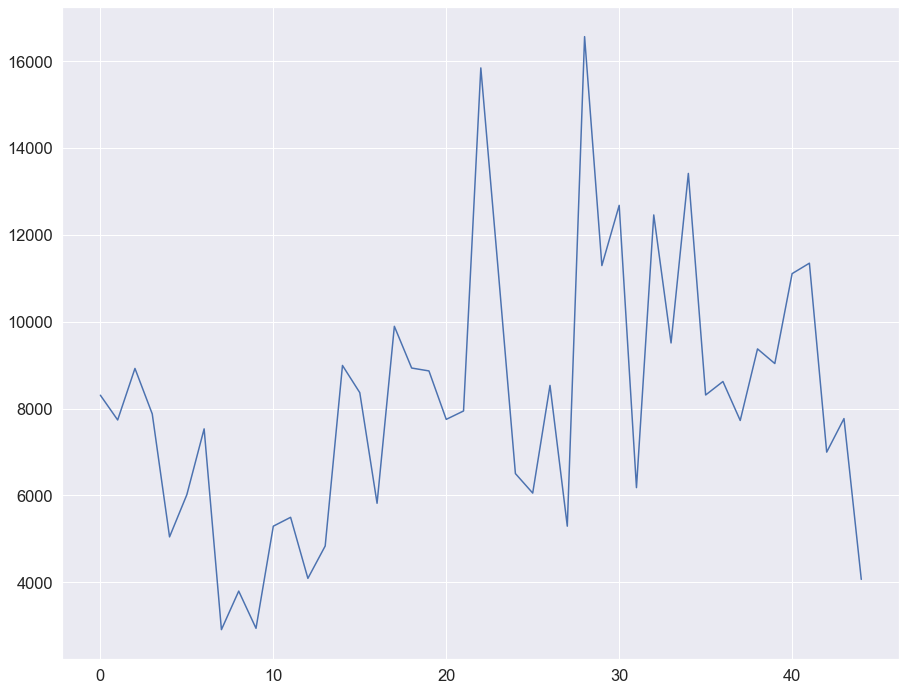

In [377]:
plt.figure(figsize = (15,12))
plt.plot(MAE)

Text(0.5, 1.0, 'Frequency of Variable Selection, n = 45')

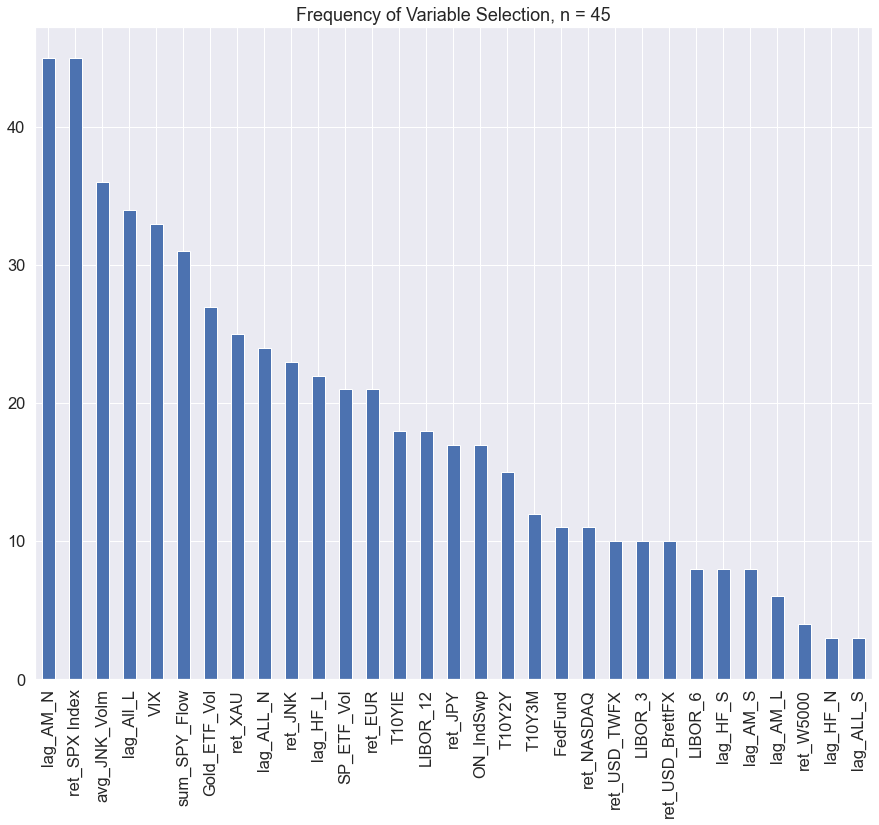

In [374]:
fig = plt.figure(figsize = (15,12))
selected = list(var_sel.values())
flat_sel = [item for sublist in selected for item in sublist]
sel = pd.Series(flat_sel)


sel.value_counts().plot(kind='bar')
plt.title("Frequency of Variable Selection, n = 45")

In [335]:
sample = df.iloc[135:540,0]

In [336]:
pred = pd.DataFrame(pred, index = sample.index)


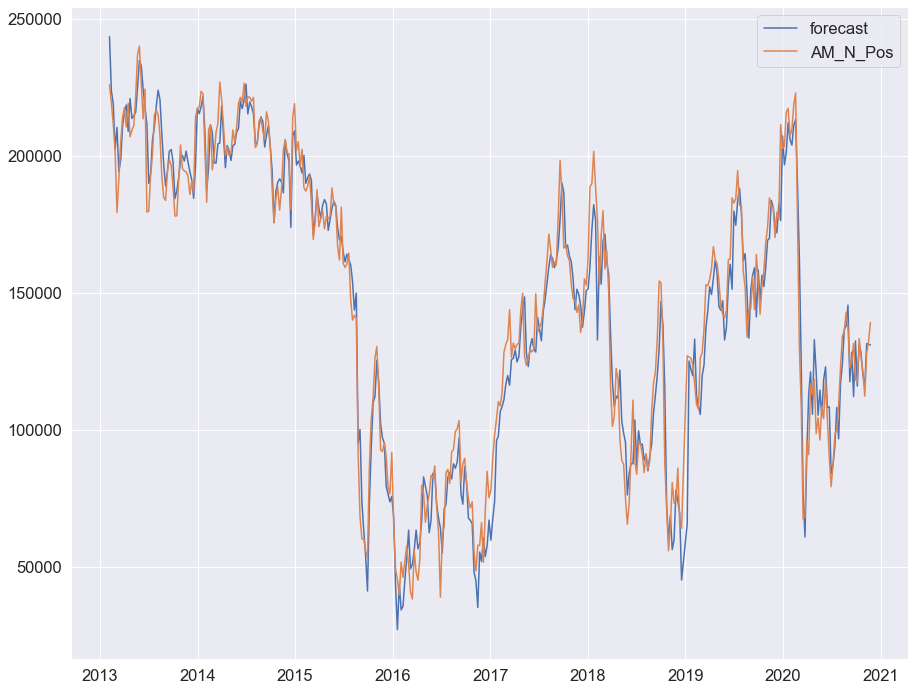

In [346]:
fig = plt.figure(figsize = (15,12))
plt.plot(pred, label = "forecast")
plt.plot(sample, label = "AM_N_Pos")
plt.legend()


MAE on training set: 6373.25
MAE on testing set: 9714.59


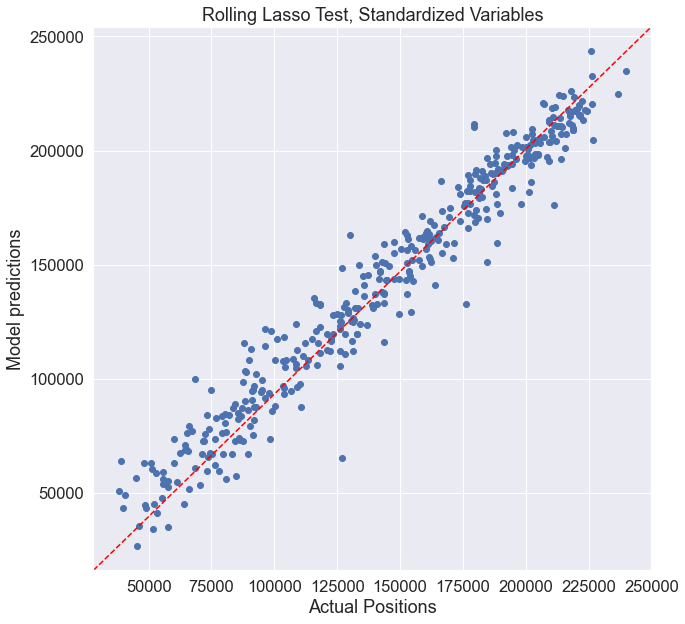

In [390]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(sample, pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Rolling Lasso Test, Standardized Variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

In [383]:
def tsplot(y, lags = None, figsize = (10,8), style = 'bmh', title = 'Return Time Series'):
        if not isinstance(y,pd.Series):
            y = pd.Series(y)
        with plt.style.context(style):
            fig = plt.figure(figsize = figsize)
            layout = (2,2)
            ts_ax = plt.subplot2grid(layout, (0,0),colspan = 2)
            acf_ax = plt.subplot2grid(layout, (1,1))
            qq_ax = plt.subplot2grid(layout,(1,0))
            y.plot(ax = ts_ax)
            ts_ax.set_title(title)
            smt.graphics.plot_acf(y,lags = lags, ax = acf_ax, alpha = .05)
            sm.qqplot(y,line = 's',ax = qq_ax)
            qq_ax.set_title('QQ Plot')
            plt.tight_layout()
        return

In [384]:
tsplot(sample-pred,title = "Errors: Rolling Lasso")

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [186]:
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

__Ridge__

In [195]:
ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
ridge.fit(X_train_std, y_train)
print("CV alpha: ",ridge.alpha_)

benchmark_res.loc['Ridge', 'MSE'] = mean_squared_error(y_test, ridge.predict(X_test_std))
benchmark_res.loc['Ridge', 'MAE'] =  mean_absolute_error(y_test, ridge.predict(X_test_std))

CV alpha:  0.1


MAE on training set: 5851.77
MAE on testing set: 11219.96


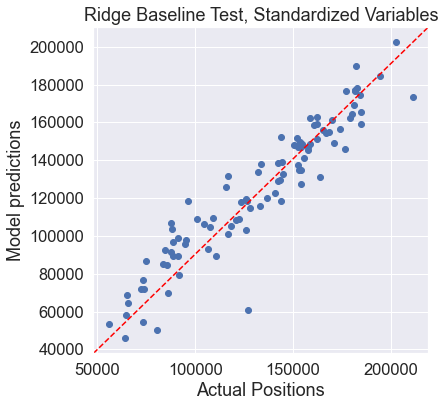

In [196]:
y_pred = ridge.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = ridge.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Ridge Baseline Test, Standardized Variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

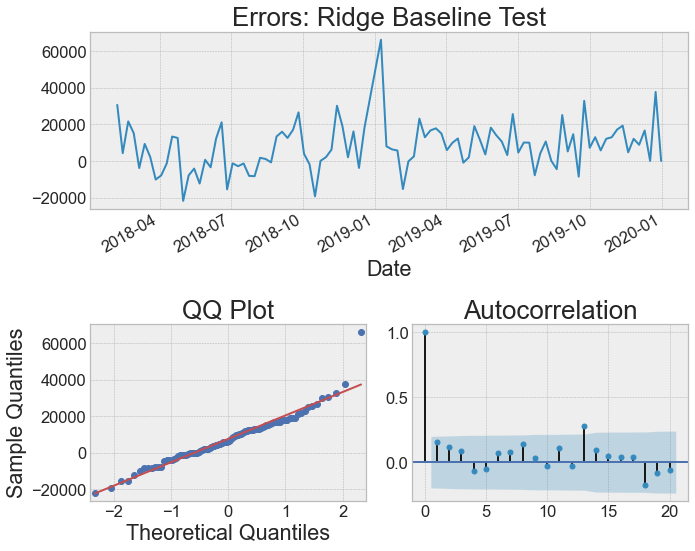

In [197]:
tsplot(y_test-y_pred,title = "Errors: Ridge Baseline Test")

(-0.05244627058970836,
 1.3213716823838757,
 -47709.394756243186,
 29441.92080149055)

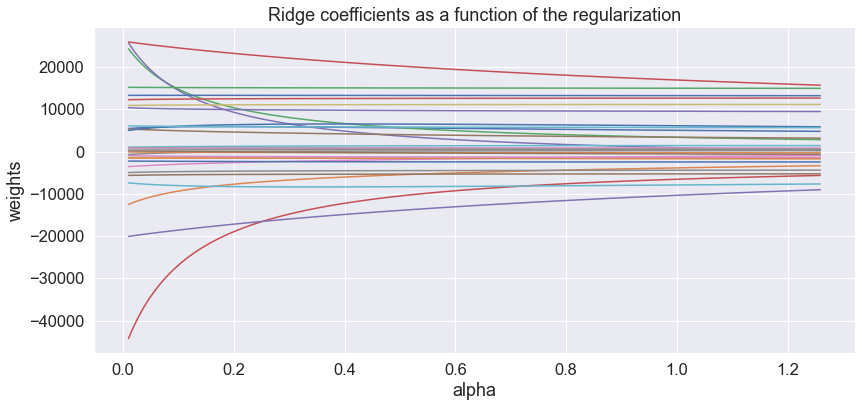

In [198]:
clf = Ridge()

coefs = []
errors = []

alphas = np.logspace(-2,.1,100)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train_std, y_train)
    coefs.append(clf.coef_)
    

plt.figure(figsize=(30, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')


__Lasso__

In [206]:
X_full = df.iloc[:,1:]
y_full = df.iloc[:,0]
X_train = X_full.iloc[30:395,:]
X_test = X_full.iloc[395:493,:]
y_train = y_full.iloc[30:395]
y_test = y_full.iloc[395:493]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)



In [207]:
lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
lasso.fit(X_train_std, y_train)

LassoCV(alphas=array([   1.25892541,    1.34676844,    1.44074081,    1.54127022,
          1.64881419,    1.76386217,    1.88693776,    2.0186011 ,
          2.1594514 ,    2.3101297 ,    2.47132176,    2.64376119,
          2.82823278,    3.0255761 ,    3.23668929,    3.46253315,
          3.70413553,    3.96259601,    4.23909088,    4.53487851,
          4.85130507,    5.18981068,    5.55193591,    5.93932887,
          6.35375264,    6.79709332,    7.27136862,    7.77873705,
          8.32150772,    8.90215085,    9....
        161.84187792,  173.13458823,  185.21526088,  198.1388769 ,
        211.96425366,  226.75431259,  242.57636554,  259.50242114,
        277.60951248,  296.98004774,  317.70218523,  339.87023462,
        363.58508612,  388.9546697 ,  416.09444628,  445.12793318,
        476.1872663 ,  509.41380148,  544.95875783,  582.98390597,
        623.66230422,  667.17908629,  713.7323038 ,  763.53382765,
        816.81031231,  873.8042273 ,  934.77496078, 1000.        ]),

In [208]:
print(np.log(lasso.alpha_))
benchmark_res.loc['Lasso', 'MSE'] = mean_squared_error(y_test, lasso.predict(X_test_std))
benchmark_res.loc['Lasso', 'MAE'] =  mean_absolute_error(y_test, lasso.predict(X_test_std))

5.896013344181723


MAE on training set: 6231.93
MAE on testing set: 12530.99


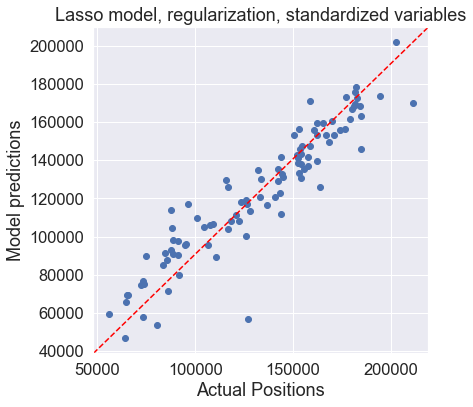

In [209]:
y_pred = lasso.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = lasso.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Lasso model, regularization, standardized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

In [210]:
print("Lasso Variable Selection:")
vars = list(X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4])
vars

Lasso Variable Selection:


['T10Y3M',
 'T10Y2Y',
 'T10YIE',
 'ret_EUR',
 'ret_SPX Index',
 'ret_XAU',
 'sum_SPY_Flow',
 'avg_JNK_Volm',
 'VIX',
 'Gold_ETF_Vol',
 'lag_AM_N',
 'lag_HF_L',
 'lag_All_L',
 'lag_ALL_N']

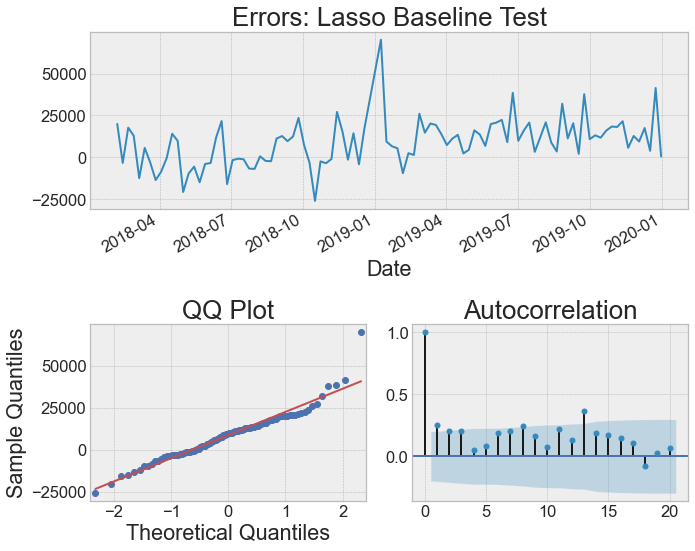

In [211]:
tsplot(y_test-y_pred,title = "Errors: Lasso Baseline Test")

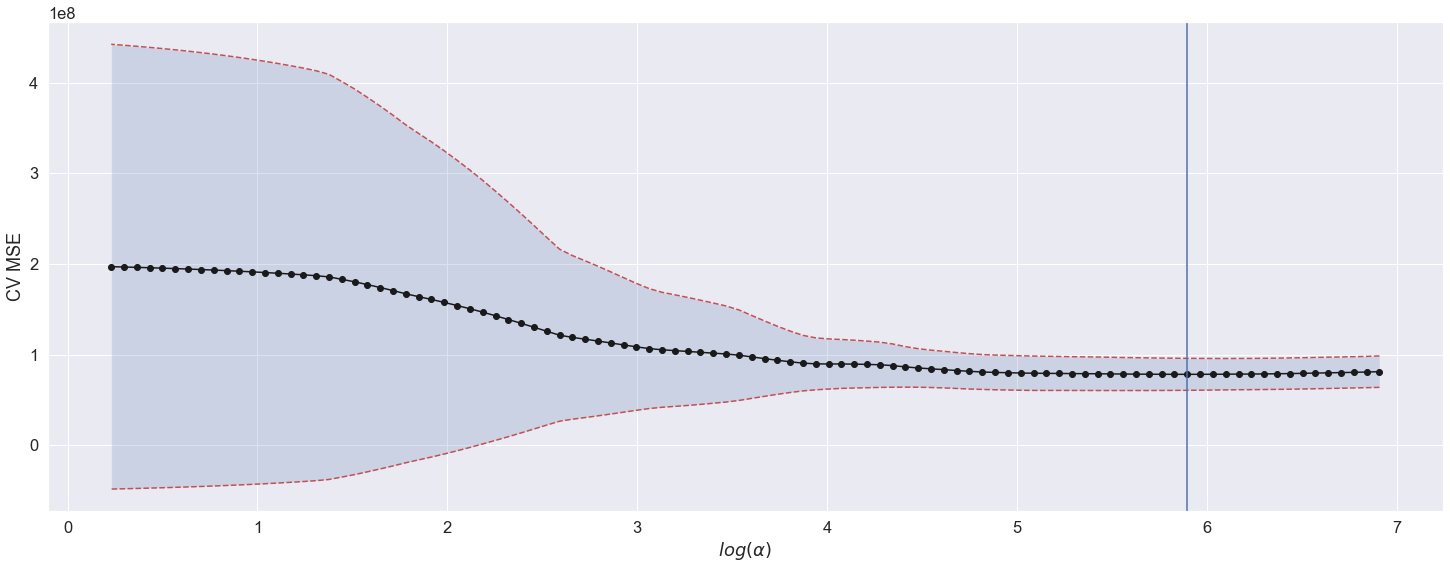

In [212]:
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)
plt.figure(figsize=(25, 9))

plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)
plt.axvline(np.log(lasso.alpha_))
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

__Random Forest__

In [213]:
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['RF', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['RF', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

y_pred = rf.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = rf.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'
print(string_score)

MAE on training set: 3095.03
MAE on testing set: 11419.73


MAE on training set: 3095.03
MAE on testing set: 11419.73


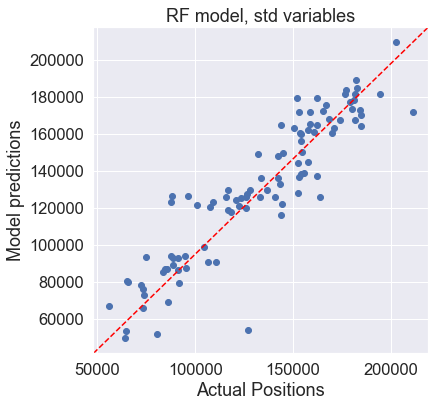

In [214]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('RF model, std variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

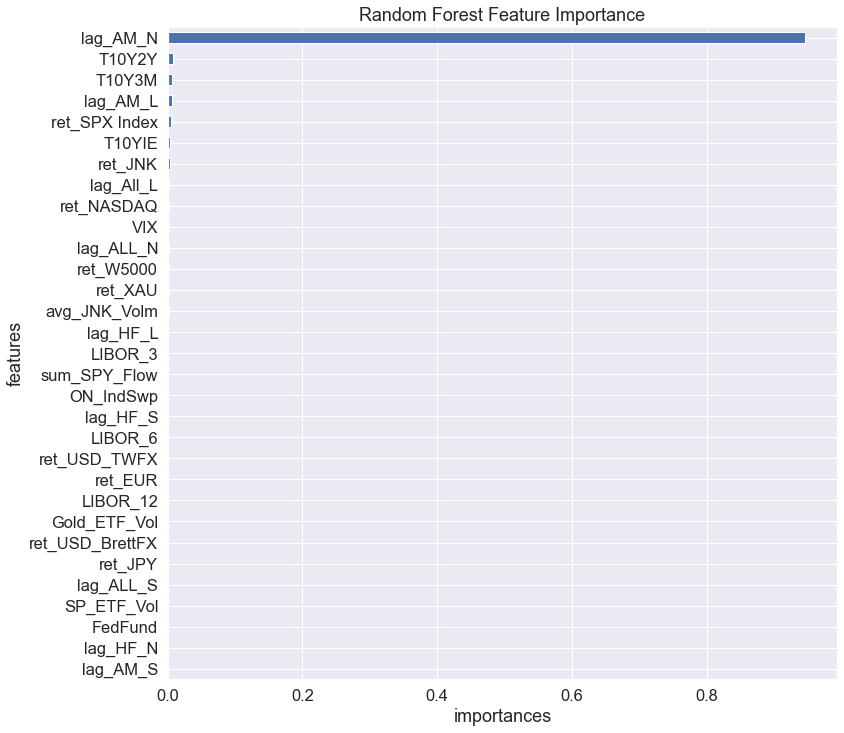

In [215]:

feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Random Forest Feature Importance")
plt.show()

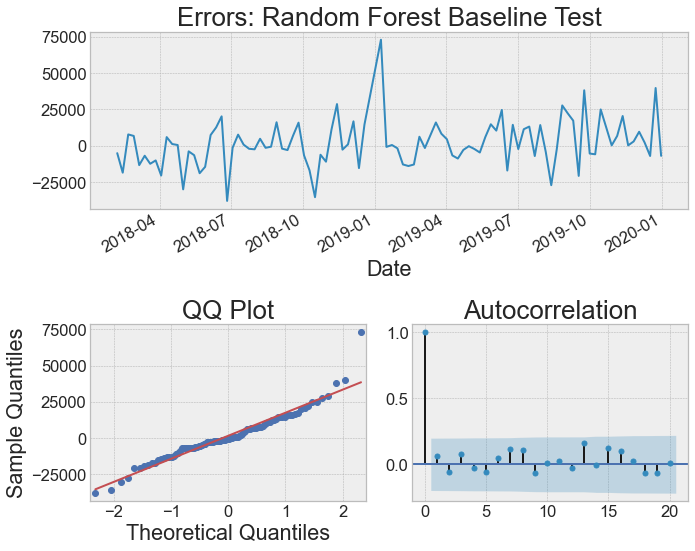

In [216]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Random Forest Baseline Test")

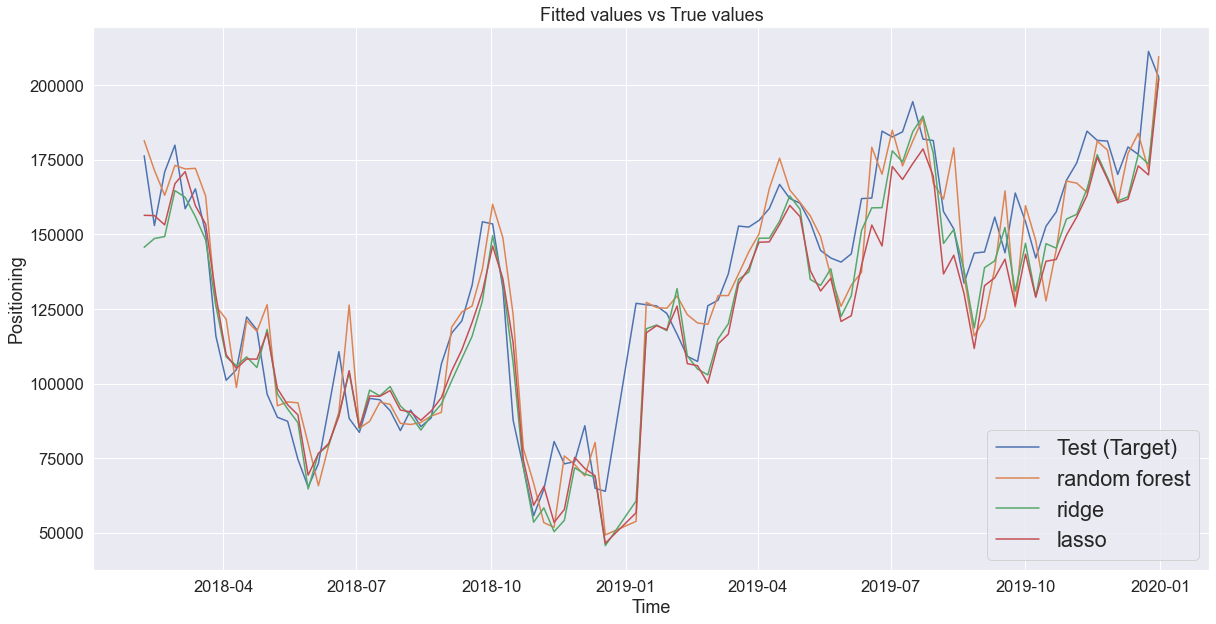

In [217]:
fig = plt.figure(figsize = [20,10])
plt.plot(X_test.index, y_test, label = 'Test (Target)')
plt.plot(X_test.index, rf.predict(X_test_std), label = 'random forest')
plt.plot(X_test.index, ridge.predict(X_test_std), label = 'ridge')
plt.plot(X_test.index, lasso.predict(X_test_std), label = 'lasso')
plt.xlabel("Time")
plt.ylabel("Positioning")
plt.title('Fitted values vs True values')
plt.legend(fontsize = 'large')

In [218]:
benchmark_res

MSE      MAE
Ridge          NaN      NaN
Lasso  2.66744e+08    12531
RF     2.54459e+08  11419.7

__Predict Change in AM Position__

In [227]:
#reimporting, so we do difference and lag at same time
train = df.iloc[30:395,:]
test = df.iloc[395:493,:]
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

In [228]:
train.columns

Index(['AM_N', 'FedFund', 'ON_IndSwp', 'LIBOR_3', 'LIBOR_6', 'LIBOR_12',
       'T10Y3M', 'T10Y2Y', 'T10YIE', 'ret_USD_TWFX', 'ret_USD_BrettFX',
       'ret_EUR', 'ret_JPY', 'ret_JNK', 'ret_SPX Index', 'ret_W5000',
       'ret_NASDAQ', 'ret_XAU', 'sum_SPY_Flow', 'avg_JNK_Volm', 'VIX',
       'SP_ETF_Vol', 'Gold_ETF_Vol', 'lag_AM_N', 'lag_AM_L', 'lag_AM_S',
       'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_S',
       'lag_ALL_N'],
      dtype='object')

In [229]:
train['d_AM_NetPos'] = train['AM_N'].diff()
test['d_AM_NetPos'] = test['AM_N'].diff()
train.iloc[0,len(train.columns)-1]=0
test.iloc[0,len(test.columns)-1]=0


In [230]:
cols = ['AM_N']  #cols to drop
train = train.drop(columns = cols)
test = test.drop(columns = cols)




In [231]:
#pop modifies original data frame
y_train = train.pop('d_AM_NetPos')
y_test = test.pop('d_AM_NetPos')

In [232]:
X_train = train
X_test = test
train['year'] = train.index.year

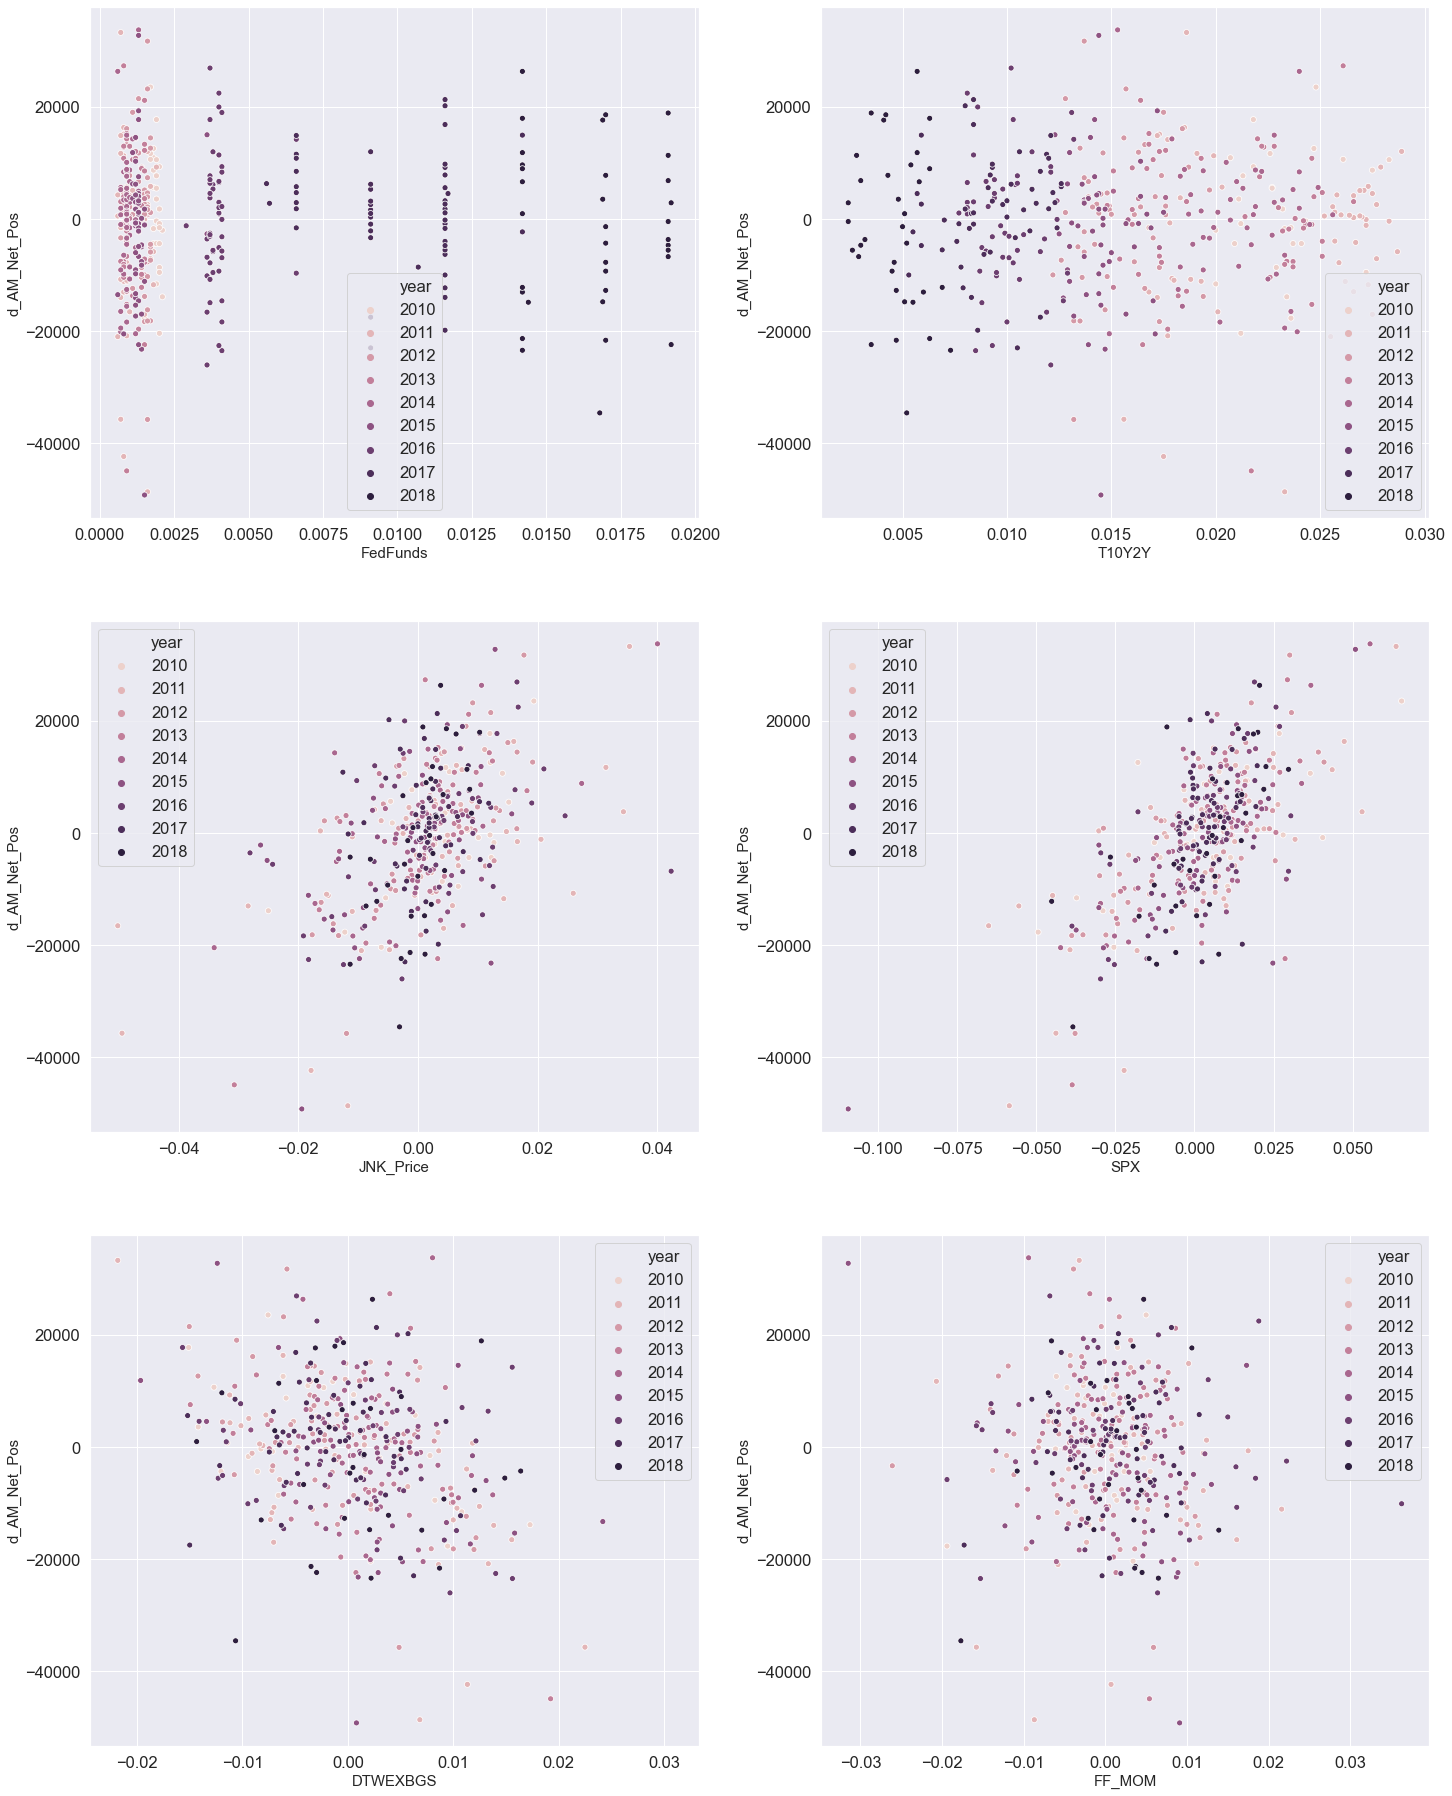

In [43]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
picklst = ['FedFunds', 'T10Y2Y', 'JNK_Price', 'SPX','DTWEXBGS','FF_MOM','SPY Flows','VIX']
for i in range(6):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Pos", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

Text(0.5, 0, 'lag_AM_NetPos')

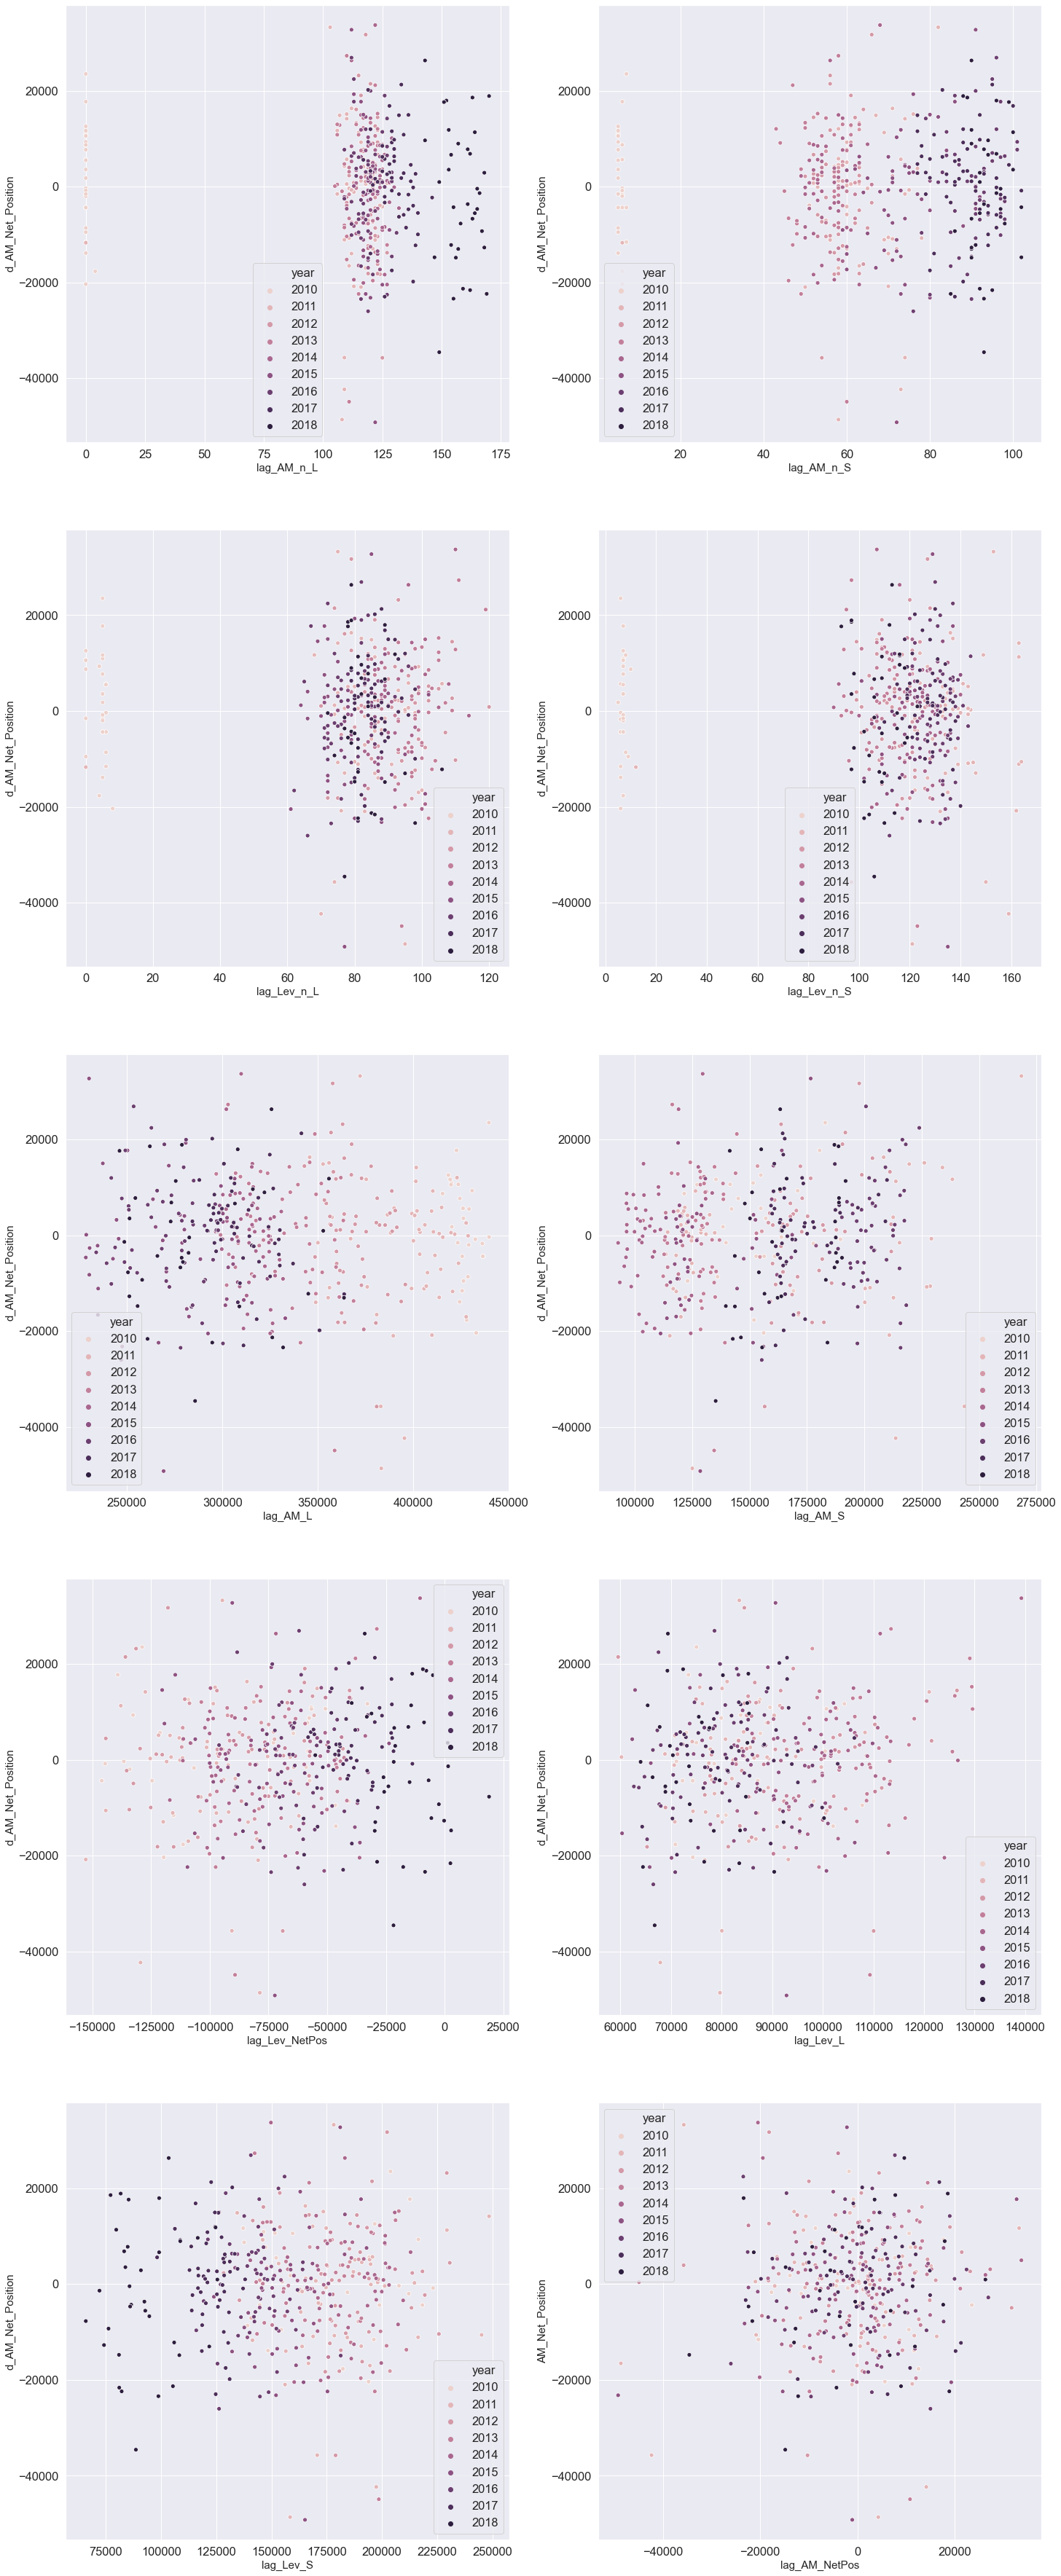

In [44]:
fig = plt.figure(figsize = (24,64))
sns.set(font_scale = 1.5)
axs = fig.subplots(5,2)
picklst = ['lag_AM_n_L', 'lag_AM_n_S', 'lag_Lev_n_L', 'lag_Lev_n_S', 'lag_AM_L', 'lag_AM_S',\
           'lag_Lev_NetPos', 'lag_Lev_L','lag_Lev_S']
for i in range(9):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

sns.scatterplot(x = y_train.shift(1), y = y_train, data = train, hue = "year", legend = "full", ax = axs[4,1])
axs[4,1].set_ylabel("AM_Net_Position", fontsize = 15)
axs[4,1].set_xlabel("lag_AM_NetPos", fontsize = 15)

In [233]:

X_train = X_train.drop(columns = ['year'])


In [234]:
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

In [235]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
scaler2.fit(X_train)
X_train_std = scaler2.transform(X_train)
X_test_std = scaler2.transform(X_test)

In [236]:
ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
ridge.fit(X_train_std, y_train)
print("CV alpha: ",ridge.alpha_)

benchmark_res.loc['Ridge', 'MSE'] = mean_squared_error(y_test, ridge.predict(X_test_std))
benchmark_res.loc['Ridge', 'MAE'] =  mean_absolute_error(y_test, ridge.predict(X_test_std))

CV alpha:  0.1


MAE on training set: 5876.42
MAE on testing set: 11202.04


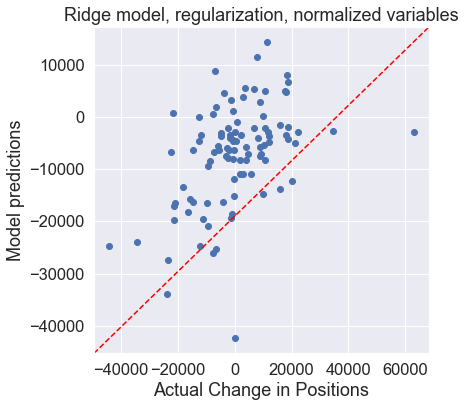

In [237]:
y_pred = ridge.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = ridge.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Ridge model, regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Change in Positions')
print(string_score)

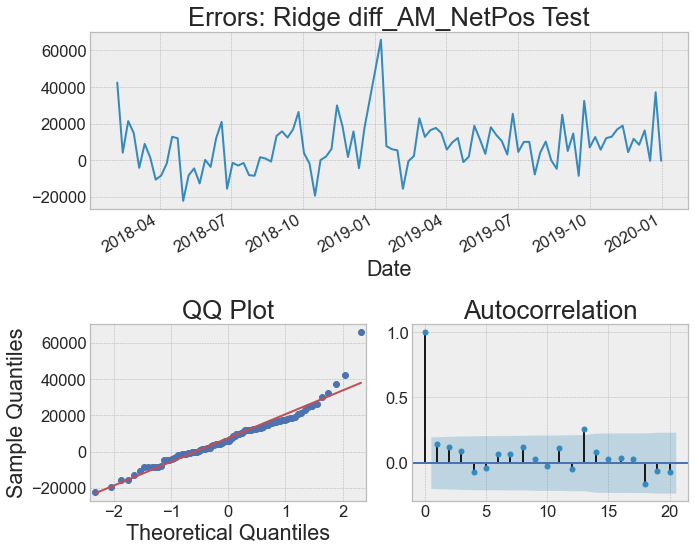

In [238]:
tsplot(y_test-y_pred,title = "Errors: Ridge diff_AM_NetPos Test")

(-0.05244627058970836,
 1.3213716823838757,
 -48742.43316939315,
 29630.354381473277)

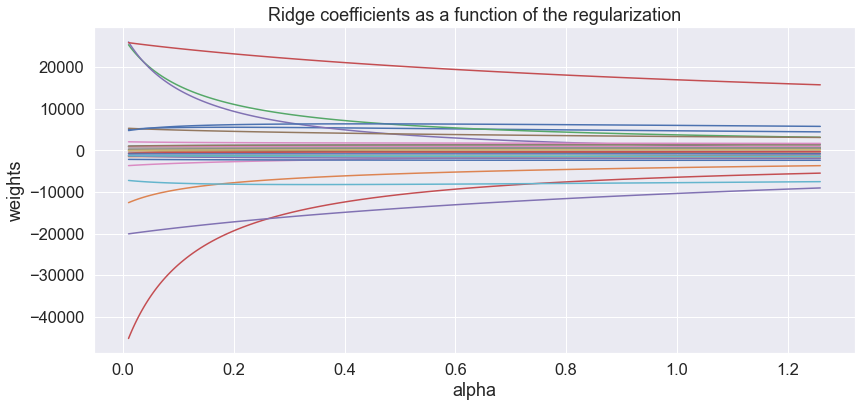

In [239]:
clf = Ridge()

coefs = []
errors = []

alphas = np.logspace(-2,.1,100)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train_std, y_train)
    coefs.append(clf.coef_)
    

plt.figure(figsize=(30, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')


In [240]:
lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
lasso.fit(X_train_std, y_train)

LassoCV(alphas=array([   1.25892541,    1.34676844,    1.44074081,    1.54127022,
          1.64881419,    1.76386217,    1.88693776,    2.0186011 ,
          2.1594514 ,    2.3101297 ,    2.47132176,    2.64376119,
          2.82823278,    3.0255761 ,    3.23668929,    3.46253315,
          3.70413553,    3.96259601,    4.23909088,    4.53487851,
          4.85130507,    5.18981068,    5.55193591,    5.93932887,
          6.35375264,    6.79709332,    7.27136862,    7.77873705,
          8.32150772,    8.90215085,    9....
        161.84187792,  173.13458823,  185.21526088,  198.1388769 ,
        211.96425366,  226.75431259,  242.57636554,  259.50242114,
        277.60951248,  296.98004774,  317.70218523,  339.87023462,
        363.58508612,  388.9546697 ,  416.09444628,  445.12793318,
        476.1872663 ,  509.41380148,  544.95875783,  582.98390597,
        623.66230422,  667.17908629,  713.7323038 ,  763.53382765,
        816.81031231,  873.8042273 ,  934.77496078, 1000.        ]),

In [241]:
print(np.log(lasso.alpha_))
benchmark_res.loc['Lasso', 'MSE'] = mean_squared_error(y_test, lasso.predict(X_test_std))
benchmark_res.loc['Lasso', 'MAE'] =  mean_absolute_error(y_test, lasso.predict(X_test_std))

5.896013344181723


In [242]:
print("Lasso Variable Selection:")
vars = list(X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4])
vars

Lasso Variable Selection:


['ret_EUR',
 'ret_JNK',
 'ret_SPX Index',
 'ret_XAU',
 'sum_SPY_Flow',
 'avg_JNK_Volm',
 'VIX',
 'Gold_ETF_Vol',
 'lag_AM_N',
 'lag_AM_S',
 'lag_HF_N',
 'lag_HF_L']

MAE on training set: 6373.25
MAE on testing set: 9714.59


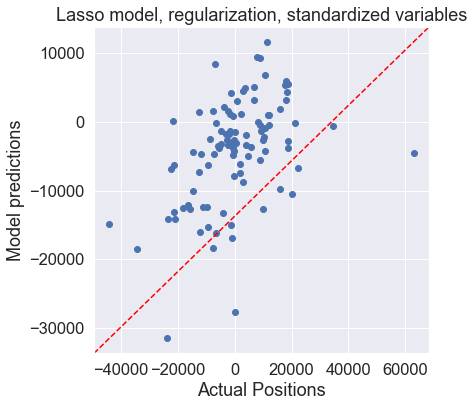

In [243]:
y_pred = lasso.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = lasso.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Lasso model, regularization, standardized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

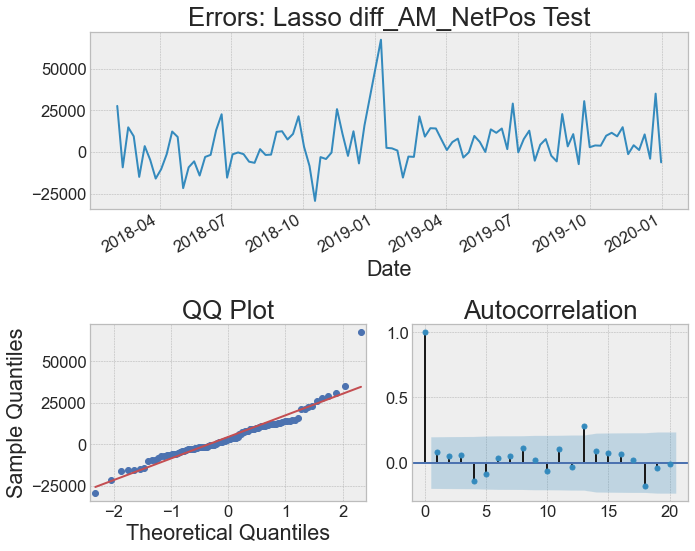

In [244]:
tsplot(y_test-y_pred,title = "Errors: Lasso diff_AM_NetPos Test")

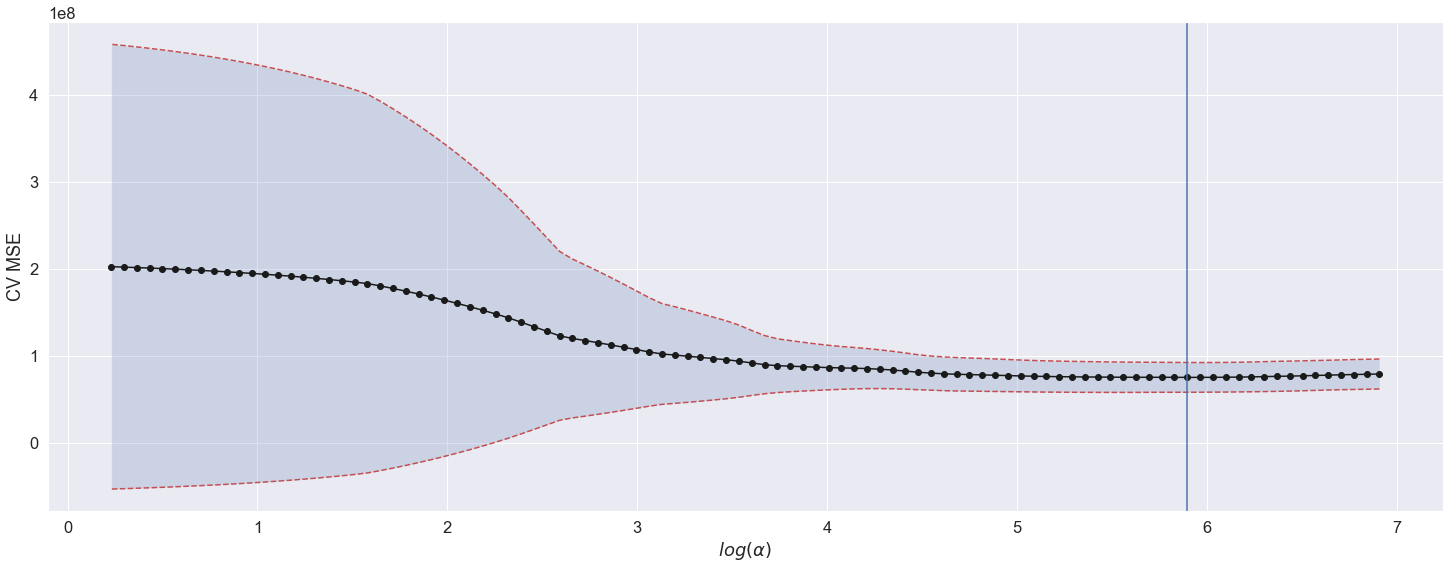

In [245]:
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)
plt.figure(figsize=(25, 9))
plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)

plt.axvline(np.log(lasso.alpha_))
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

In [246]:
X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4]

Index(['ret_EUR', 'ret_JNK', 'ret_SPX Index', 'ret_XAU', 'sum_SPY_Flow',
       'avg_JNK_Volm', 'VIX', 'Gold_ETF_Vol', 'lag_AM_N', 'lag_AM_S',
       'lag_HF_N', 'lag_HF_L'],
      dtype='object')

In [247]:
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['RF', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['RF', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

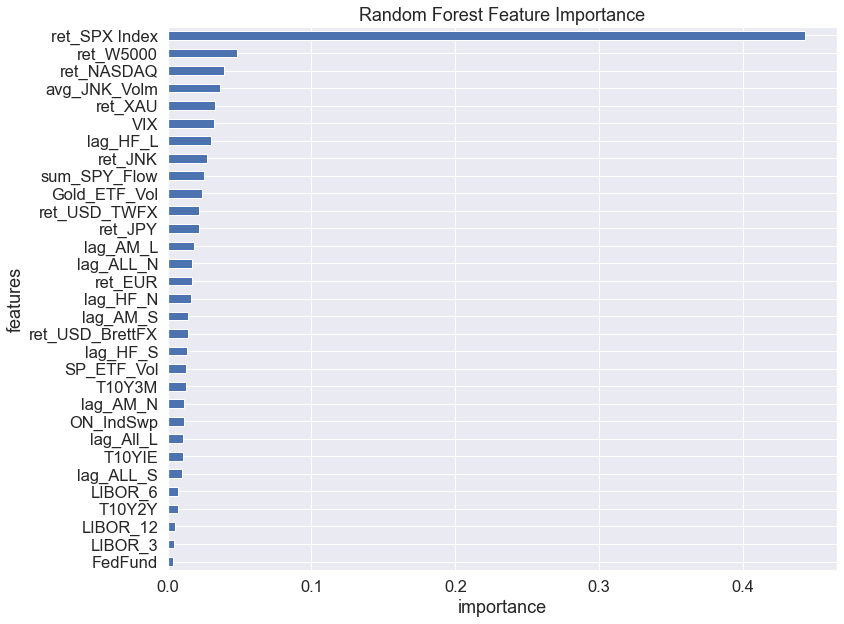

In [248]:
feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,10])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importance')
plt.title("Random Forest Feature Importance")
plt.show()

MAE on training set: 6373.25
MAE on testing set: 9714.59


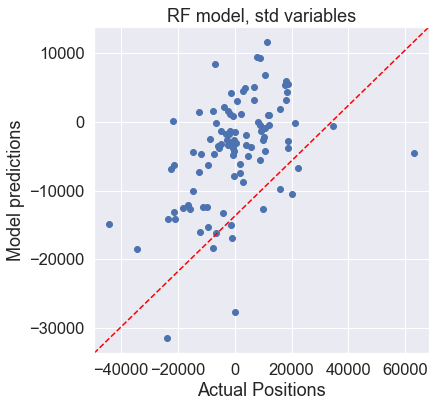

In [249]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('RF model, std variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

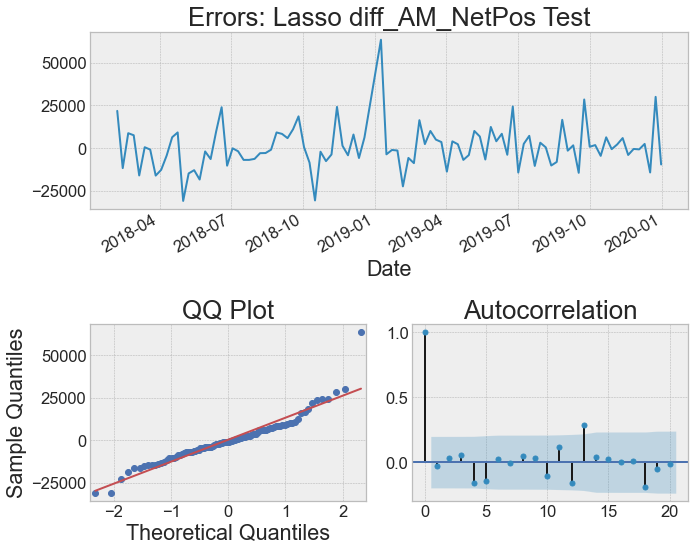

In [250]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Lasso diff_AM_NetPos Test")

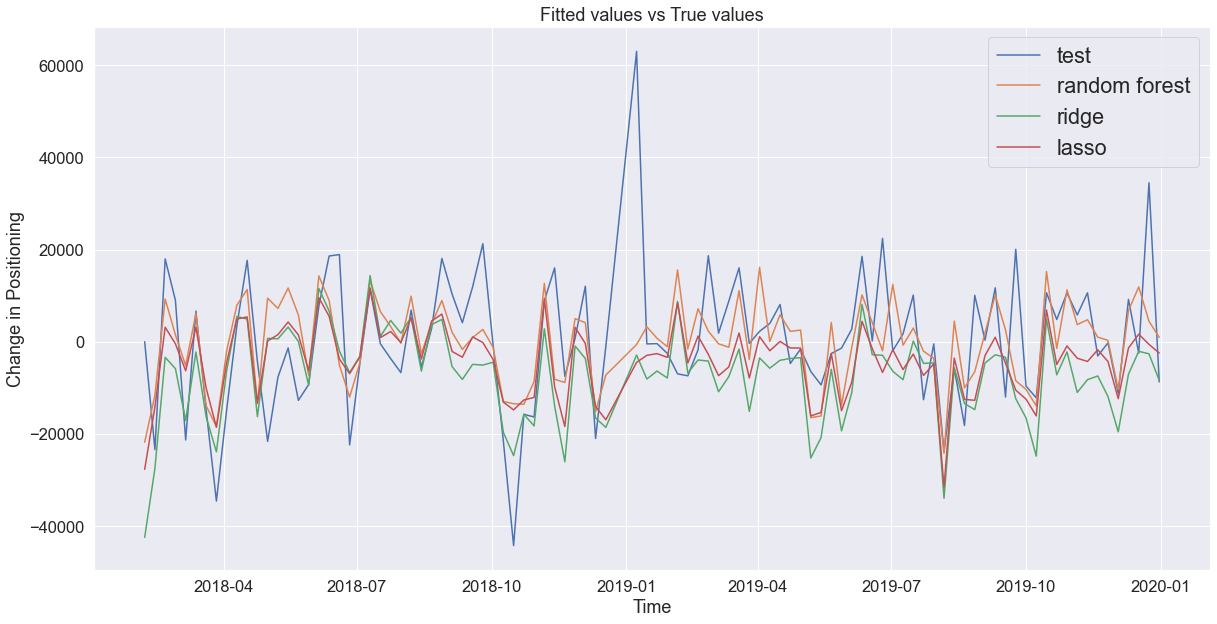

In [251]:
fig = plt.figure(figsize = [20,10])
plt.plot(test.index, y_test, label = 'test')
plt.plot(test.index, rf.predict(X_test_std), label = 'random forest')
plt.plot(test.index, ridge.predict(X_test_std), label = 'ridge')
plt.plot(test.index, lasso.predict(X_test_std), label = 'lasso')
plt.xlabel("Time")
plt.ylabel("Change in Positioning")
plt.title('Fitted values vs True values')
plt.legend(fontsize = 'large')

In [252]:
benchmark_res

MSE      MAE
Ridge  2.27714e+08    11202
Lasso  1.87641e+08  9714.59
RF     1.66707e+08  9045.01

In [253]:
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
print(feat_importance.sort_values(ascending = False)[0:10])

ret_SPX Index    0.443547
ret_W5000        0.048417
ret_NASDAQ       0.039004
avg_JNK_Volm     0.036386
ret_XAU          0.032958
VIX              0.032274
lag_HF_L         0.029896
ret_JNK          0.027344
sum_SPY_Flow     0.024978
Gold_ETF_Vol     0.023614
dtype: float64
